# EDA

1. KONFIGURASI DATASET

In [ ]:
import os
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from glob import glob


DATASET_PATH = '/kaggle/input/vehicle-images-dataset' 

if not os.path.exists(DATASET_PATH):
    print(f"Path tidak ditemukan: {DATASET_PATH}")
    print("Mohon sesuaikan variabel 'DATASET_PATH' dengan lokasi folder dataset Anda.")
else:
    print(f"Direktori Dataset ditemukan: {DATASET_PATH}")


Direktori Dataset ditemukan: /kaggle/input/vehicle-images-dataset


2. MEMBUAT DATAFRAME (Scanning Data)

In [ ]:
data = []
print("Sedang memindai file dan mengecek resolusi gambar...")

classes = os.listdir(DATASET_PATH)
for class_name in classes:
    class_path = os.path.join(DATASET_PATH, class_name)
    
   
    if os.path.isdir(class_path):
        
        images = glob(os.path.join(class_path, "*.[jJpP]*"))
        
        for img_path in images:
            try:
                with Image.open(img_path) as img:
                    width, height = img.size
                    
                data.append({
                    "filename": os.path.basename(img_path),
                    "class": class_name,
                    "path": img_path,
                    "width": width,
                    "height": height,
                    "aspect_ratio": width / height
                })
            except Exception as e:
                print(f"File corrupt atau error: {img_path}")

df = pd.DataFrame(data)
print(f"Selesai! Total gambar ditemukan: {len(df)}")
print(df.head())


Sedang memindai file dan mengecek resolusi gambar...
Selesai! Total gambar ditemukan: 15645
           filename class                                               path  \
0  Image_015080.jpg   Van  /kaggle/input/vehicle-images-dataset/Van/Image...   
1  Image_014628.jpg   Van  /kaggle/input/vehicle-images-dataset/Van/Image...   
2  Image_015013.jpg   Van  /kaggle/input/vehicle-images-dataset/Van/Image...   
3  Image_015930.jpg   Van  /kaggle/input/vehicle-images-dataset/Van/Image...   
4  Image_016292.jpg   Van  /kaggle/input/vehicle-images-dataset/Van/Image...   

   width  height  aspect_ratio  
0     81     104      0.778846  
1    150     151      0.993377  
2     84      68      1.235294  
3     75      70      1.071429  
4    119      95      1.252632  


3. VISUALISASI 1: DISTRIBUSI KELAS 

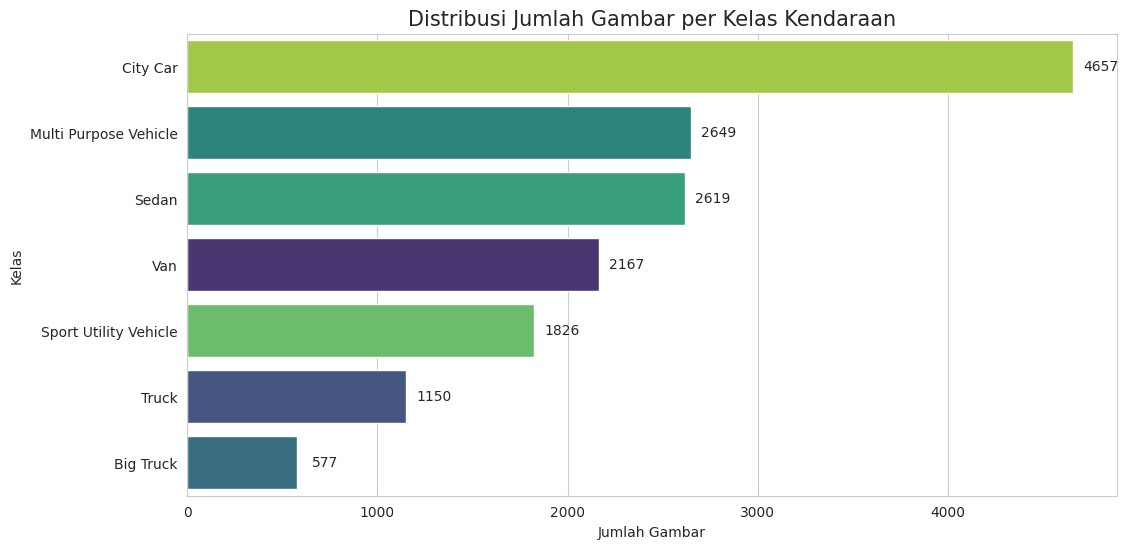


Persentase Distribusi Kelas:
class
City Car                 29.766699
Multi Purpose Vehicle    16.931927
Sedan                    16.740173
Van                      13.851071
Sport Utility Vehicle    11.671461
Truck                     7.350591
Big Truck                 3.688079
Name: proportion, dtype: float64


In [ ]:
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

ax = sns.countplot(
    y="class", 
    data=df, 
    order=df['class'].value_counts().index, 
    palette="viridis",
    hue="class",      
    legend=False      
)

for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}', 
                (p.get_width(), p.get_y() + p.get_height() / 2), 
                ha = 'center', va = 'center', 
                xytext = (20, 0), 
                textcoords = 'offset points')

plt.title("Distribusi Jumlah Gambar per Kelas Kendaraan", fontsize=15)
plt.xlabel("Jumlah Gambar")
plt.ylabel("Kelas")
plt.show()

print("\nPersentase Distribusi Kelas:")
print(df['class'].value_counts(normalize=True) * 100)

4. VISUALISASI 2: SAMPEL GAMBAR (Grid)

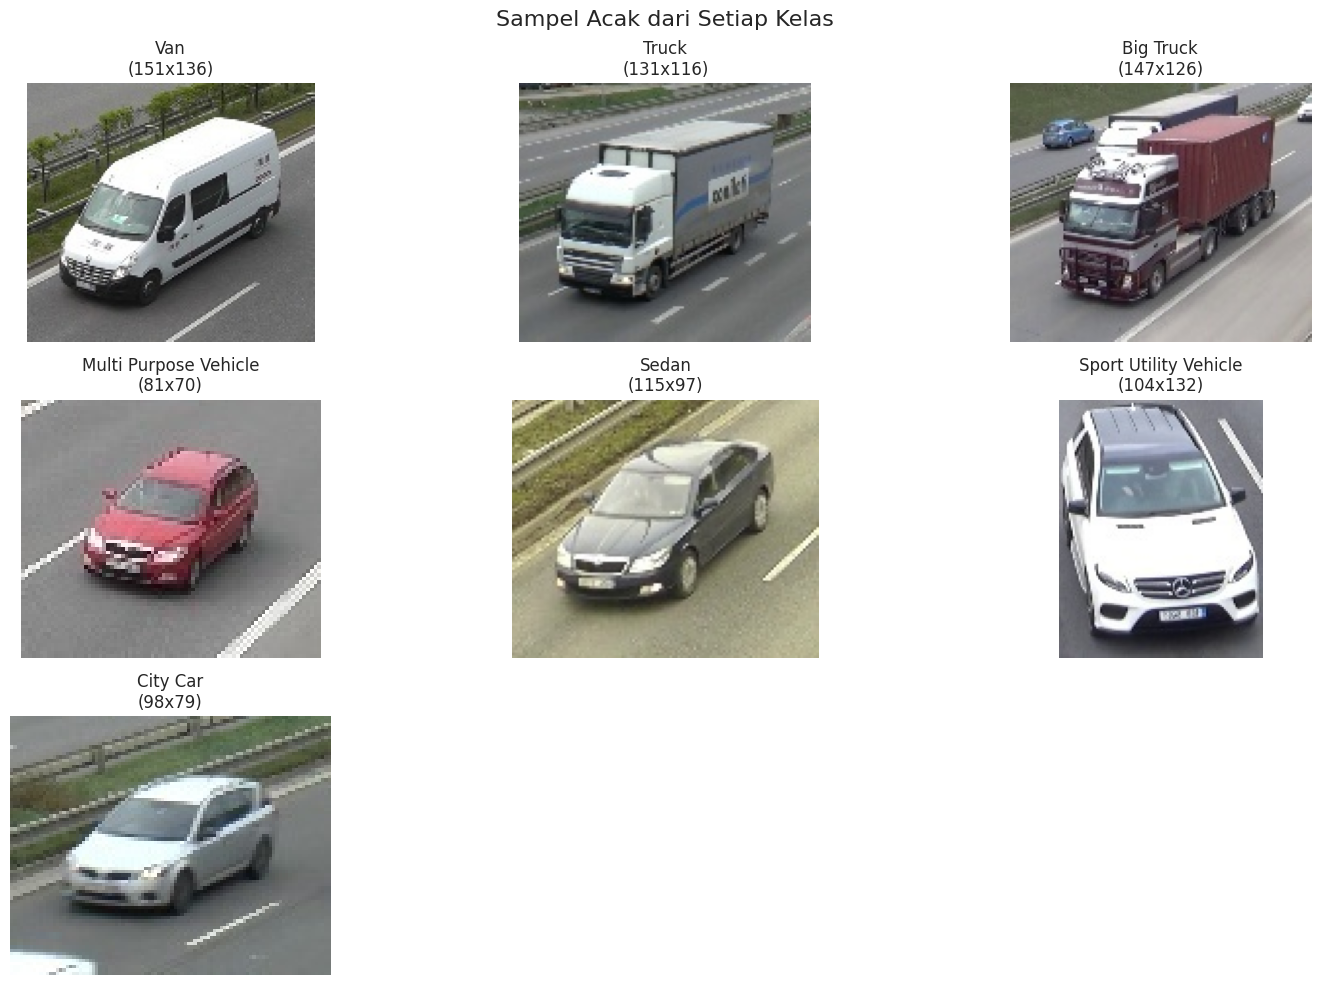

In [ ]:
unique_classes = df['class'].unique()
plt.figure(figsize=(15, 10))
plt.suptitle("Sampel Acak dari Setiap Kelas", fontsize=16)

for i, class_name in enumerate(unique_classes):
    sample_row = df[df['class'] == class_name].sample(1).iloc[0]
    img = Image.open(sample_row['path'])
    
    plt.subplot(3, 3, i + 1) 
    plt.imshow(img)
    plt.title(f"{class_name}\n({sample_row['width']}x{sample_row['height']})")
    plt.axis('off')

plt.tight_layout()
plt.show()


5. VISUALISASI 3: ANALISIS RESOLUSI

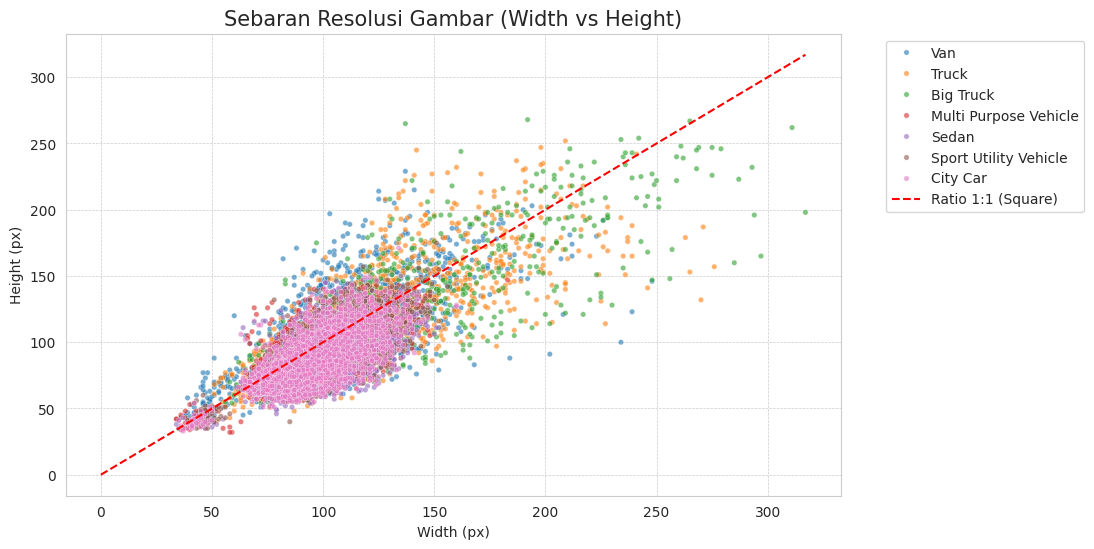


Statistik Resolusi Gambar:
              width        height
count  15645.000000  15645.000000
mean      99.498818     91.436050
std       25.579359     27.131729
min       34.000000     32.000000
25%       84.000000     73.000000
50%       94.000000     85.000000
75%      110.000000    102.000000
max      317.000000    268.000000


In [ ]:
plt.figure(figsize=(10, 6))

# Scatter plot Width vs Height
sns.scatterplot(data=df, x="width", y="height", hue="class", alpha=0.6, s=15)

# Tambahkan garis diagonal (Square)
max_dim = max(df['width'].max(), df['height'].max())
plt.plot([0, max_dim], [0, max_dim], 'r--', label='Ratio 1:1 (Square)')

plt.title("Sebaran Resolusi Gambar (Width vs Height)", fontsize=15)
plt.xlabel("Width (px)")
plt.ylabel("Height (px)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

# Statistik Resolusi
print("\nStatistik Resolusi Gambar:")
print(df[['width', 'height']].describe())

# Model Base

1. DATA SPLITTING (Train 80%, Val 10%, Test 10%)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import os

train_val_df, test_df = train_test_split(
    df, test_size=0.1, random_state=42, stratify=df['class']
)

train_df, val_df = train_test_split(
    train_val_df, test_size=0.1111, random_state=42, stratify=train_val_df['class']
)

print(f"Jumlah Data Train : {len(train_df)} gambar")
print(f"Jumlah Data Val   : {len(val_df)} gambar")
print(f"Jumlah Data Test  : {len(test_df)} gambar (Disimpan untuk Evaluasi Akhir)")

Jumlah Data Train : 12515 gambar
Jumlah Data Val   : 1565 gambar
Jumlah Data Test  : 1565 gambar (Disimpan untuk Evaluasi Akhir)


2. IMAGE DATA GENERATOR (Augmentasi & Normalisasi)

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (128, 128)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='class',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='path',
    y_col='class',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='path',
    y_col='class',
    target_size=IMG_SIZE,
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

Found 12515 validated image filenames belonging to 7 classes.
Found 1565 validated image filenames belonging to 7 classes.
Found 1565 validated image filenames belonging to 7 classes.


3. MENGHITUNG CLASS WEIGHTS

In [ ]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))
print(f"\nClass Weights: {class_weights_dict}")



Class Weights: {0: np.float64(3.8698206555349413), 1: np.float64(0.4799616490891659), 2: np.float64(0.8437268253219173), 3: np.float64(0.8533924309580634), 4: np.float64(1.2237215214627946), 5: np.float64(1.9433229813664596), 6: np.float64(1.0316544390404747)}


4. ARSITEKTUR MODEL BASE (Custom CNN)

In [ ]:
model_base = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(128, 128, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(7, activation='softmax')
])

model_base.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])
model_base.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 63, 63, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 30, 30, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 6, 6, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,113,031 (19.50 MB)

 Trainable params: 5,112,071 (19.50 MB)

 Non-trainable params: 960 (3.75 KB)

5. TRAINING MODEL

In [ ]:
checkpoint = ModelCheckpoint(
    'model_base_best.h5',      
    monitor='val_accuracy',    
    save_best_only=True,       
    mode='max',                
    verbose=1
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss'),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3, monitor='val_loss'),
    checkpoint 
]

print("\nMulai Training Model Base...")
history_base = model_base.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    callbacks=callbacks,
    class_weight=class_weights_dict
)

model_base.save('model_base_final.h5')
print("Model berhasil disimpan ke 'model_base_best.h5' dan 'model_base_final.h5'")




Mulai Training Model Base...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25


I0000 00:00:1766472311.245579     125 service.cc:152] XLA service 0x7df12c015990 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1766472311.245613     125 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1766472311.829369     125 cuda_dnn.cc:529] Loaded cuDNN version 91002


  3/392 ━━━━━━━━━━━━━━━━━━━━ 32s 84ms/step - accuracy: 0.1580 - loss: 4.0795

I0000 00:00:1766472316.396338     125 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.2668 - loss: 2.5946
Epoch 1: val_accuracy improved from -inf to 0.06070, saving model to model_base_best.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 95s 221ms/step - accuracy: 0.2668 - loss: 2.5930 - val_accuracy: 0.0607 - val_loss: 3.3057 - learning_rate: 0.0010
Epoch 2/25
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.3321 - loss: 1.4578
Epoch 2: val_accuracy improved from 0.06070 to 0.12204, saving model to model_base_best.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 57s 145ms/step - accuracy: 0.3321 - loss: 1.4577 - val_accuracy: 0.1220 - val_loss: 6.0034 - learning_rate: 0.0010
Epoch 3/25
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.3615 - loss: 1.2920
Epoch 3: val_accuracy improved from 0.12204 to 0.43450, saving model to model_base_best.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 56s 143ms/step - accuracy: 0.3615 - loss: 1.2920 - val_accuracy: 0.4345 - val_loss: 1.3865 - learning_rate: 0.0010
Epoch 4/25
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.3957 - loss: 1.2444
Epoch 4: val_accuracy did not improve from 0.43450
392/392 ━━━━━━━━━━━━━━━━━━━━ 55s 141ms/step - accuracy: 0.3957 - loss: 1.2443 - val_accuracy: 0.3003 - val_loss: 3.4559 - learning_rate: 0.0010
Epoch 5/25
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.4078 - loss: 1.2244
Epoch 5: val_accuracy did not improve from 0.43450
392/392 ━━━━━━━━━━━━━━━━━━━━ 56s 142ms/step - accuracy: 0.4079 - loss: 1.2243 - val_accuracy: 0.2160 - val_loss: 3.8254 - learning_rate: 0.0010
Epoch 6/25
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.4456 - loss: 1.1232
Epoch 6: val_accuracy improved from 0.43450 to 0.51118, saving model to model_base_best.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 56s 143ms/step - accuracy: 0.4457 - loss: 1.1231 - val_accuracy: 0.5112 - val_loss: 1.1847 - learning_rate: 0.0010
Epoch 7/25
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.4752 - loss: 1.0385
Epoch 7: val_accuracy did not improve from 0.51118
392/392 ━━━━━━━━━━━━━━━━━━━━ 57s 145ms/step - accuracy: 0.4752 - loss: 1.0384 - val_accuracy: 0.2505 - val_loss: 5.3161 - learning_rate: 0.0010
Epoch 8/25
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.4930 - loss: 0.9700
Epoch 8: val_accuracy did not improve from 0.51118
392/392 ━━━━━━━━━━━━━━━━━━━━ 56s 144ms/step - accuracy: 0.4931 - loss: 0.9700 - val_accuracy: 0.3642 - val_loss: 2.0537 - learning_rate: 0.0010
Epoch 9/25
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.5203 - loss: 0.9138
Epoch 9: val_accuracy did not improve from 0.51118
392/392 ━━━━━━━━━━━━━━━━━━━━ 56s 143ms/step - accuracy: 0.5204 - loss: 0.9137 - val_accuracy: 0.5112 - val_loss: 1.6780 - learning_rate: 0.0010
Epoch 1

392/392 ━━━━━━━━━━━━━━━━━━━━ 58s 148ms/step - accuracy: 0.5650 - loss: 0.8102 - val_accuracy: 0.5585 - val_loss: 1.4089 - learning_rate: 5.0000e-04
Epoch 11/25
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.6086 - loss: 0.7205
Epoch 11: val_accuracy improved from 0.55847 to 0.69712, saving model to model_base_best.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 56s 142ms/step - accuracy: 0.6086 - loss: 0.7205 - val_accuracy: 0.6971 - val_loss: 0.7429 - learning_rate: 5.0000e-04
Epoch 12/25
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.6257 - loss: 0.6819
Epoch 12: val_accuracy did not improve from 0.69712
392/392 ━━━━━━━━━━━━━━━━━━━━ 56s 143ms/step - accuracy: 0.6257 - loss: 0.6819 - val_accuracy: 0.6939 - val_loss: 0.7581 - learning_rate: 5.0000e-04
Epoch 13/25
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.6393 - loss: 0.6570
Epoch 13: val_accuracy improved from 0.69712 to 0.70415, saving model to model_base_best.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 60s 154ms/step - accuracy: 0.6393 - loss: 0.6569 - val_accuracy: 0.7042 - val_loss: 0.6746 - learning_rate: 5.0000e-04
Epoch 14/25
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.6546 - loss: 0.6433
Epoch 14: val_accuracy did not improve from 0.70415
392/392 ━━━━━━━━━━━━━━━━━━━━ 57s 146ms/step - accuracy: 0.6546 - loss: 0.6432 - val_accuracy: 0.6952 - val_loss: 0.7304 - learning_rate: 5.0000e-04
Epoch 15/25
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.6710 - loss: 0.6039
Epoch 15: val_accuracy did not improve from 0.70415
392/392 ━━━━━━━━━━━━━━━━━━━━ 58s 148ms/step - accuracy: 0.6710 - loss: 0.6039 - val_accuracy: 0.6581 - val_loss: 0.9161 - learning_rate: 5.0000e-04
Epoch 16/25
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.6913 - loss: 0.5659
Epoch 16: val_accuracy did not improve from 0.70415
392/392 ━━━━━━━━━━━━━━━━━━━━ 58s 147ms/step - accuracy: 0.6913 - loss: 0.5659 - val_accuracy: 0.6920 - val_loss: 0.6867 - learning_ra

392/392 ━━━━━━━━━━━━━━━━━━━━ 59s 151ms/step - accuracy: 0.7202 - loss: 0.5179 - val_accuracy: 0.7457 - val_loss: 0.6371 - learning_rate: 2.5000e-04
Epoch 18/25
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.7389 - loss: 0.4792
Epoch 18: val_accuracy improved from 0.74569 to 0.76486, saving model to model_base_best.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 58s 147ms/step - accuracy: 0.7389 - loss: 0.4792 - val_accuracy: 0.7649 - val_loss: 0.6162 - learning_rate: 2.5000e-04
Epoch 19/25
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.7500 - loss: 0.4463
Epoch 19: val_accuracy improved from 0.76486 to 0.78466, saving model to model_base_best.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 56s 144ms/step - accuracy: 0.7500 - loss: 0.4463 - val_accuracy: 0.7847 - val_loss: 0.5842 - learning_rate: 2.5000e-04
Epoch 20/25
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.7601 - loss: 0.4329
Epoch 20: val_accuracy improved from 0.78466 to 0.79042, saving model to model_base_best.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 57s 144ms/step - accuracy: 0.7601 - loss: 0.4329 - val_accuracy: 0.7904 - val_loss: 0.5450 - learning_rate: 2.5000e-04
Epoch 21/25
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.7632 - loss: 0.4207
Epoch 21: val_accuracy did not improve from 0.79042
392/392 ━━━━━━━━━━━━━━━━━━━━ 70s 178ms/step - accuracy: 0.7633 - loss: 0.4207 - val_accuracy: 0.7796 - val_loss: 0.6433 - learning_rate: 2.5000e-04
Epoch 22/25
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.7730 - loss: 0.4116
Epoch 22: val_accuracy improved from 0.79042 to 0.80319, saving model to model_base_best.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 58s 148ms/step - accuracy: 0.7730 - loss: 0.4116 - val_accuracy: 0.8032 - val_loss: 0.4915 - learning_rate: 2.5000e-04
Epoch 23/25
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.7782 - loss: 0.3956
Epoch 23: val_accuracy did not improve from 0.80319
392/392 ━━━━━━━━━━━━━━━━━━━━ 77s 197ms/step - accuracy: 0.7782 - loss: 0.3956 - val_accuracy: 0.7732 - val_loss: 0.6672 - learning_rate: 2.5000e-04
Epoch 24/25
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.7899 - loss: 0.3706
Epoch 24: val_accuracy did not improve from 0.80319
392/392 ━━━━━━━━━━━━━━━━━━━━ 57s 145ms/step - accuracy: 0.7899 - loss: 0.3706 - val_accuracy: 0.7840 - val_loss: 0.6790 - learning_rate: 2.5000e-04
Epoch 25/25
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.7965 - loss: 0.3680
Epoch 25: val_accuracy improved from 0.80319 to 0.82556, saving model to model_base_best.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 58s 148ms/step - accuracy: 0.7965 - loss: 0.3680 - val_accuracy: 0.8256 - val_loss: 0.4561 - learning_rate: 2.5000e-04


Model berhasil disimpan ke 'model_base_best.h5' dan 'model_base_final.h5'


6. PLOT HASIL TRAINING

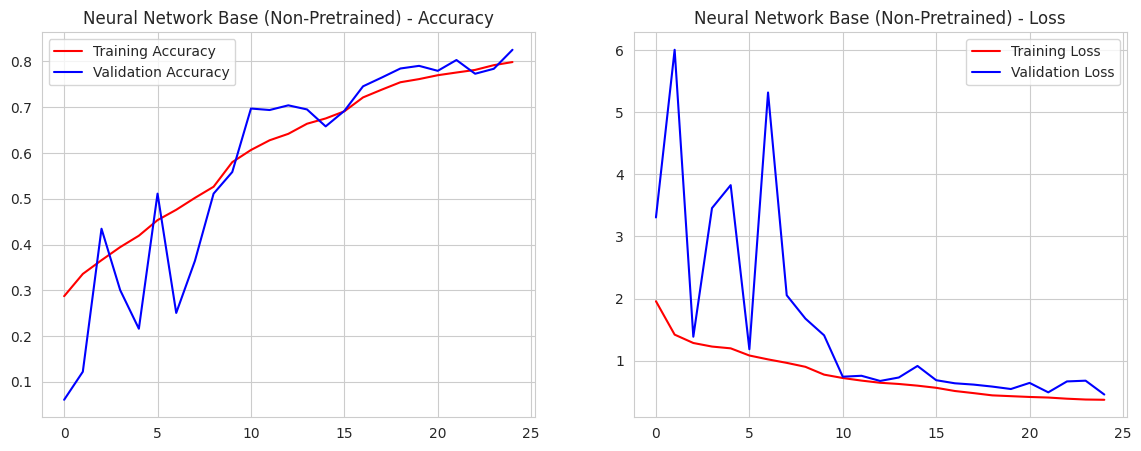

In [ ]:
def plot_history(history, title="Model History"):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(14, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'r', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.legend()
    plt.show()

plot_history(history_base, "Neural Network Base (Non-Pretrained)")

Sedang melakukan prediksi pada Data Test...
1565/1565 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step

=== Laporan Klasifikasi Model Base ===
                       precision    recall  f1-score   support

            Big Truck       0.98      0.98      0.98        58
             City Car       0.84      0.75      0.79       466
Multi Purpose Vehicle       0.67      0.73      0.70       265
                Sedan       0.84      0.83      0.83       262
Sport Utility Vehicle       0.83      0.91      0.87       182
                Truck       0.99      0.99      0.99       115
                  Van       0.96      1.00      0.98       217

             accuracy                           0.84      1565
            macro avg       0.87      0.88      0.88      1565
         weighted avg       0.84      0.84      0.84      1565



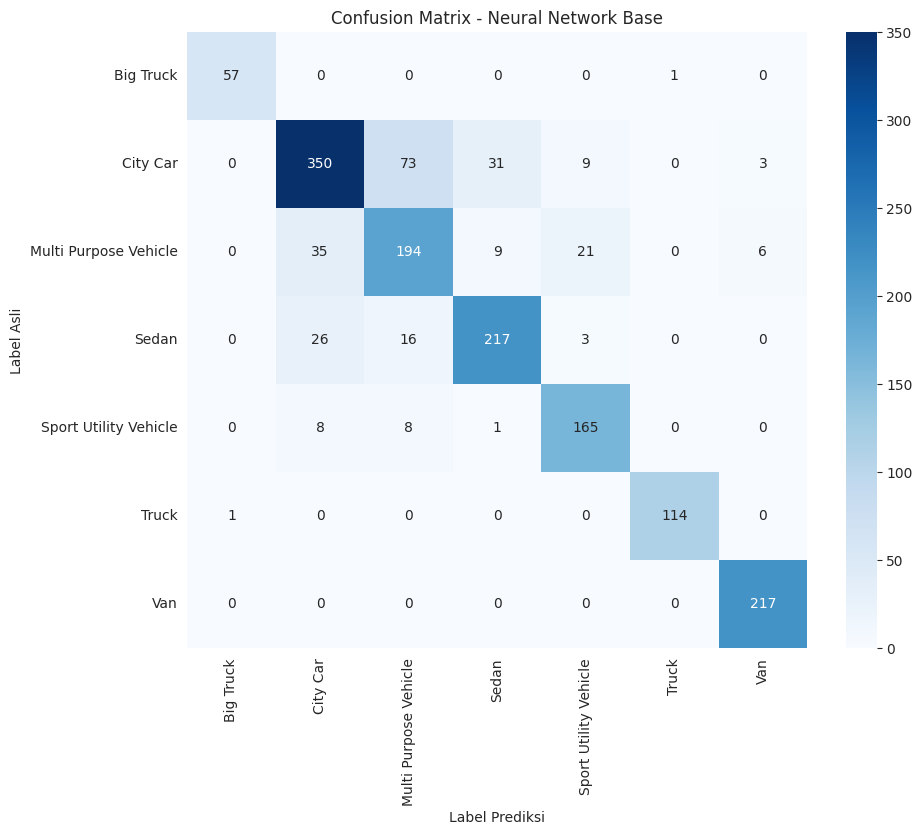

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# 1. Load Bobot Terbaik (Opsional tapi disarankan)
# Jika Anda ingin hasil terbaik dari Epoch 23, bukan Epoch 25.
# Namun, karena kita pakai restore_best_weights=True di EarlyStopping, 
# model_base otomatis sudah kembali ke kondisi terbaik (sekitar epoch 23/24).

# 2. Prediksi Data Test
print("Sedang melakukan prediksi pada Data Test...")
test_generator.reset() # Reset agar urutan file dimulai dari awal
predictions = model_base.predict(test_generator, verbose=1)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

# 3. Classification Report
class_names = list(test_generator.class_indices.keys())
print("\n=== Laporan Klasifikasi Model Base ===")
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

# 4. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Neural Network Base')
plt.ylabel('Label Asli')
plt.xlabel('Label Prediksi')
plt.show()

# Transfer Learning 

TAHAP 1: PERSIAPAN DATA KHUSUS TRANSFER LEARNING (Resolusi 224x224)

In [ ]:
from tensorflow.keras.applications import MobileNetV2, ResNet50V2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


IMG_SIZE_TL = (224, 224)
BATCH_SIZE = 32

print("Menyiapkan Data Generator untuk Transfer Learning (224x224)...")


train_gen_tl = train_datagen.flow_from_dataframe(
    dataframe=train_df, 
    x_col='path', y_col='class',
    target_size=IMG_SIZE_TL, 
    batch_size=BATCH_SIZE, 
    class_mode='categorical'
)


val_gen_tl = val_test_datagen.flow_from_dataframe(
    dataframe=val_df, 
    x_col='path', y_col='class',
    target_size=IMG_SIZE_TL, 
    batch_size=BATCH_SIZE, 
    class_mode='categorical', 
    shuffle=False
)


test_gen_tl = val_test_datagen.flow_from_dataframe(
    dataframe=test_df, 
    x_col='path', y_col='class',
    target_size=IMG_SIZE_TL, 
    batch_size=1, 
    class_mode='categorical', 
    shuffle=False
)


Menyiapkan Data Generator untuk Transfer Learning (224x224)...
Found 12515 validated image filenames belonging to 7 classes.
Found 1565 validated image filenames belonging to 7 classes.
Found 1565 validated image filenames belonging to 7 classes.


TAHAP 2: FUNGSI PEMBUAT MODEL (BUILDER FUNCTION)

In [ ]:
def build_transfer_model(model_type, input_shape=(224, 224, 3), num_classes=7):
    """
    Fungsi praktis untuk membangun model transfer learning
    agar kita tidak perlu menulis ulang kode untuk setiap model.
    """
    
    if model_type == 'MobileNetV2':
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    elif model_type == 'ResNet50V2':
        base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=input_shape)
    
    
    base_model.trainable = False 
    
   
    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)        
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)                    
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs, name=model_type)
    
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


# TAHAP 3: TRAINING MODEL 1 - MOBILENET V2

In [ ]:
print("\n" + "="*40)
print(" MULAI TRAINING MODEL 1: MOBILENET V2 ")
print("="*40)

model_mobile = build_transfer_model('MobileNetV2')
model_mobile.summary()

ckpt_mobile = ModelCheckpoint(
    'model_mobilenetv2_best.h5', 
    monitor='val_accuracy', save_best_only=True, mode='max', verbose=1
)
callbacks_mobile = [
    EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss'),
    ReduceLROnPlateau(factor=0.5, patience=3, monitor='val_loss'),
    ckpt_mobile
]

history_mobile = model_mobile.fit(
    train_gen_tl,
    validation_data=val_gen_tl,
    epochs=20, 
    callbacks=callbacks_mobile,
    class_weight=class_weights_dict
)



 MULAI TRAINING MODEL 1: MOBILENET V2 


Model: "MobileNetV2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,587,719 (9.87 MB)

 Trainable params: 329,735 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.2524 - loss: 1.8814
Epoch 1: val_accuracy improved from -inf to 0.47093, saving model to model_mobilenetv2_best.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 155s 375ms/step - accuracy: 0.2526 - loss: 1.8806 - val_accuracy: 0.4709 - val_loss: 1.3173 - learning_rate: 1.0000e-04
Epoch 2/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.4393 - loss: 1.1995
Epoch 2: val_accuracy improved from 0.47093 to 0.51438, saving model to model_mobilenetv2_best.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 136s 346ms/step - accuracy: 0.4393 - loss: 1.1994 - val_accuracy: 0.5144 - val_loss: 1.1695 - learning_rate: 1.0000e-04
Epoch 3/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.4938 - loss: 1.0522
Epoch 3: val_accuracy improved from 0.51438 to 0.56933, saving model to model_mobilenetv2_best.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 137s 349ms/step - accuracy: 0.4938 - loss: 1.0522 - val_accuracy: 0.5693 - val_loss: 1.0692 - learning_rate: 1.0000e-04
Epoch 4/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.5276 - loss: 0.9619
Epoch 4: val_accuracy improved from 0.56933 to 0.58722, saving model to model_mobilenetv2_best.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 138s 352ms/step - accuracy: 0.5276 - loss: 0.9619 - val_accuracy: 0.5872 - val_loss: 1.0259 - learning_rate: 1.0000e-04
Epoch 5/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.5554 - loss: 0.8974
Epoch 5: val_accuracy improved from 0.58722 to 0.61597, saving model to model_mobilenetv2_best.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 139s 354ms/step - accuracy: 0.5554 - loss: 0.8974 - val_accuracy: 0.6160 - val_loss: 0.9676 - learning_rate: 1.0000e-04
Epoch 6/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.5888 - loss: 0.8520
Epoch 6: val_accuracy improved from 0.61597 to 0.64153, saving model to model_mobilenetv2_best.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 140s 357ms/step - accuracy: 0.5888 - loss: 0.8520 - val_accuracy: 0.6415 - val_loss: 0.9400 - learning_rate: 1.0000e-04
Epoch 7/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.5863 - loss: 0.8369
Epoch 7: val_accuracy did not improve from 0.64153
392/392 ━━━━━━━━━━━━━━━━━━━━ 136s 347ms/step - accuracy: 0.5863 - loss: 0.8368 - val_accuracy: 0.6390 - val_loss: 0.9135 - learning_rate: 1.0000e-04
Epoch 8/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.6043 - loss: 0.7942
Epoch 8: val_accuracy did not improve from 0.64153
392/392 ━━━━━━━━━━━━━━━━━━━━ 136s 348ms/step - accuracy: 0.6043 - loss: 0.7942 - val_accuracy: 0.6275 - val_loss: 0.9188 - learning_rate: 1.0000e-04
Epoch 9/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.6031 - loss: 0.7839
Epoch 9: val_accuracy improved from 0.64153 to 0.64665, saving model to model_mobilenetv2_best.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 136s 347ms/step - accuracy: 0.6031 - loss: 0.7838 - val_accuracy: 0.6466 - val_loss: 0.8936 - learning_rate: 1.0000e-04
Epoch 10/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.6236 - loss: 0.7475
Epoch 10: val_accuracy improved from 0.64665 to 0.65751, saving model to model_mobilenetv2_best.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 138s 351ms/step - accuracy: 0.6236 - loss: 0.7475 - val_accuracy: 0.6575 - val_loss: 0.8733 - learning_rate: 1.0000e-04
Epoch 11/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.6281 - loss: 0.7287
Epoch 11: val_accuracy improved from 0.65751 to 0.66134, saving model to model_mobilenetv2_best.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 137s 350ms/step - accuracy: 0.6281 - loss: 0.7287 - val_accuracy: 0.6613 - val_loss: 0.8560 - learning_rate: 1.0000e-04
Epoch 12/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.6438 - loss: 0.7117
Epoch 12: val_accuracy did not improve from 0.66134
392/392 ━━━━━━━━━━━━━━━━━━━━ 139s 354ms/step - accuracy: 0.6438 - loss: 0.7117 - val_accuracy: 0.6505 - val_loss: 0.8575 - learning_rate: 1.0000e-04
Epoch 13/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.6467 - loss: 0.7148
Epoch 13: val_accuracy improved from 0.66134 to 0.67029, saving model to model_mobilenetv2_best.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 142s 362ms/step - accuracy: 0.6467 - loss: 0.7148 - val_accuracy: 0.6703 - val_loss: 0.8216 - learning_rate: 1.0000e-04
Epoch 14/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.6605 - loss: 0.6726
Epoch 14: val_accuracy improved from 0.67029 to 0.67604, saving model to model_mobilenetv2_best.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 137s 350ms/step - accuracy: 0.6605 - loss: 0.6726 - val_accuracy: 0.6760 - val_loss: 0.8193 - learning_rate: 1.0000e-04
Epoch 15/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.6618 - loss: 0.6662
Epoch 15: val_accuracy did not improve from 0.67604
392/392 ━━━━━━━━━━━━━━━━━━━━ 135s 344ms/step - accuracy: 0.6618 - loss: 0.6662 - val_accuracy: 0.6703 - val_loss: 0.8208 - learning_rate: 1.0000e-04
Epoch 16/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.6655 - loss: 0.6729
Epoch 16: val_accuracy improved from 0.67604 to 0.67668, saving model to model_mobilenetv2_best.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 136s 346ms/step - accuracy: 0.6655 - loss: 0.6729 - val_accuracy: 0.6767 - val_loss: 0.8157 - learning_rate: 1.0000e-04
Epoch 17/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.6581 - loss: 0.6746
Epoch 17: val_accuracy improved from 0.67668 to 0.67859, saving model to model_mobilenetv2_best.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 136s 347ms/step - accuracy: 0.6581 - loss: 0.6745 - val_accuracy: 0.6786 - val_loss: 0.7898 - learning_rate: 1.0000e-04
Epoch 18/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.6843 - loss: 0.6312
Epoch 18: val_accuracy did not improve from 0.67859
392/392 ━━━━━━━━━━━━━━━━━━━━ 135s 345ms/step - accuracy: 0.6843 - loss: 0.6312 - val_accuracy: 0.6786 - val_loss: 0.7950 - learning_rate: 1.0000e-04
Epoch 19/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.6768 - loss: 0.6314
Epoch 19: val_accuracy improved from 0.67859 to 0.69137, saving model to model_mobilenetv2_best.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 137s 350ms/step - accuracy: 0.6768 - loss: 0.6314 - val_accuracy: 0.6914 - val_loss: 0.7711 - learning_rate: 1.0000e-04
Epoch 20/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.6883 - loss: 0.6101
Epoch 20: val_accuracy improved from 0.69137 to 0.69585, saving model to model_mobilenetv2_best.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 141s 359ms/step - accuracy: 0.6882 - loss: 0.6101 - val_accuracy: 0.6958 - val_loss: 0.7805 - learning_rate: 1.0000e-04


TAHAP 3A: VISUALISASI HASIL TRAINING (MOBILENET) dan EVALUASI AKHIR PADA DATA TEST

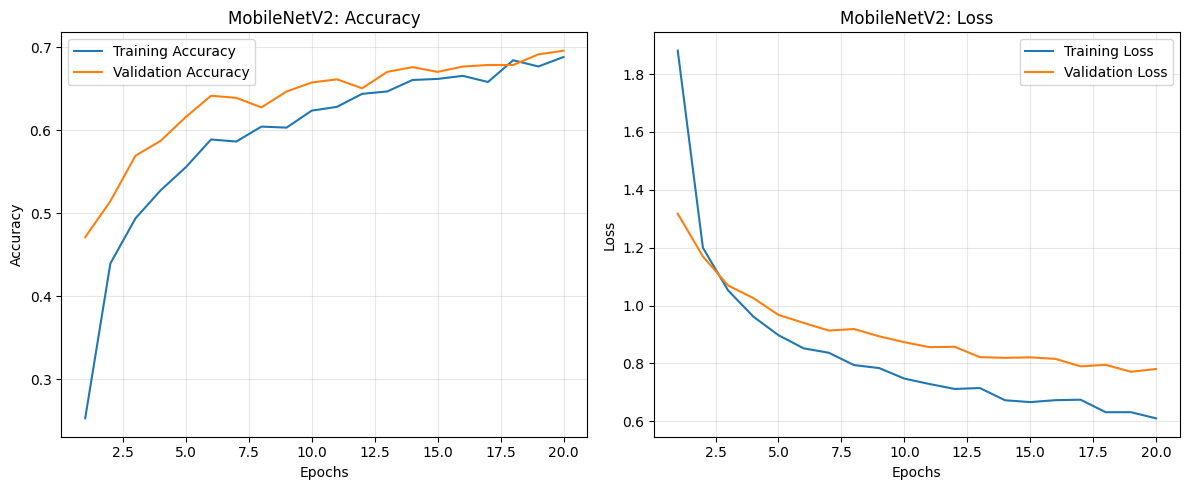


Executing Evaluation on Test Set (MobileNetV2 Frozen)...


Model loaded successfully from: /kaggle/working/model_mobilenetv2_best.h5
1565/1565 ━━━━━━━━━━━━━━━━━━━━ 52s 32ms/step

=== CLASSIFICATION REPORT (MOBILENET V2 - FROZEN) ===
                       precision    recall  f1-score   support

            Big Truck       0.95      0.97      0.96        58
             City Car       0.73      0.61      0.66       466
Multi Purpose Vehicle       0.55      0.58      0.56       265
                Sedan       0.61      0.76      0.68       262
Sport Utility Vehicle       0.64      0.62      0.63       182
                Truck       0.94      0.97      0.95       115
                  Van       0.89      0.89      0.89       217

             accuracy                           0.71      1565
            macro avg       0.76      0.77      0.76      1565
         weighted avg       0.72      0.71      0.71      1565



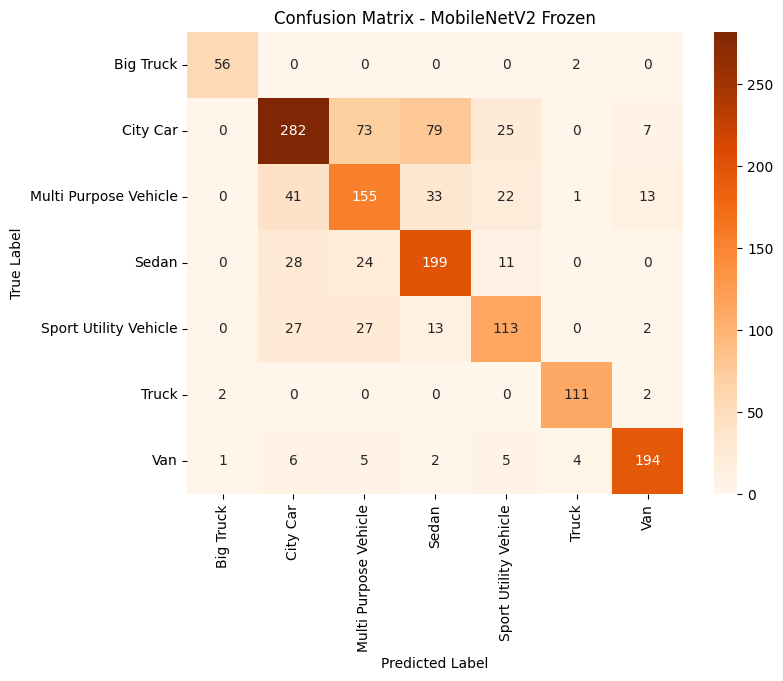

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix


def plot_mobile_history(history):

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('MobileNetV2 (Frozen Phase): Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
   
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('MobileNetV2 (Frozen Phase): Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

if 'history_mobile' in globals():
    plot_mobile_history(history_mobile)
else:
    print("Warning: Variabel 'history_mobile' tidak ditemukan. Pastikan proses training sudah dijalankan.")


print("\nExecuting Evaluation on Test Set (MobileNetV2 Model)...")

try:
   
    best_mobile_model = load_model('model_mobilenetv2_best.h5')
    print("Model berhasil dimuat: model_mobilenetv2_best.h5")
    

    if 'test_gen_tl' in globals():
        test_gen_tl.reset()
        
        predictions = best_mobile_model.predict(test_gen_tl, verbose=1)
        y_pred = np.argmax(predictions, axis=1)
        y_true = test_gen_tl.classes
        class_names = list(test_gen_tl.class_indices.keys())

        print("\n=== CLASSIFICATION REPORT (MOBILENET V2) ===")
        print(classification_report(y_true, y_pred, target_names=class_names))
        
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', 
                    xticklabels=class_names, yticklabels=class_names)
        plt.title('Confusion Matrix - MobileNetV2')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()
    else:
        print("Error: Variabel 'test_gen_tl' tidak ditemukan. Harap definisikan generator data test.")

except Exception as e:
    print(f"Evaluasi gagal: {e}")
    print("Kemungkinan file 'model_mobilenetv2_best.h5' belum terbentuk atau path salah.")

TAHAP 3B: FINE TUNING MOBILENET V2

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix


print("Memuat Model MobileNetV2 Terbaik (Frozen)...")
model_mobile_ft = load_model('model_mobilenetv2_best.h5')


base_model_mobile = model_mobile_ft.layers[1] 
base_model_mobile.trainable = True

fine_tune_at = 100 

for layer in base_model_mobile.layers[:fine_tune_at]:
    layer.trainable = False

print(f"Total layer MobileNetV2: {len(base_model_mobile.layers)}")
print(f"Mulai Fine-Tuning dari layer ke: {fine_tune_at}")


model_mobile_ft.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


print("\n=== MULAI FINE-TUNING MOBILENET V2 ===")

ckpt_mobile_ft = ModelCheckpoint(
    'model_mobilenetv2_finetuned.h5', 
    monitor='val_accuracy', save_best_only=True, mode='max', verbose=1
)

callbacks_mobile_ft = [
    EarlyStopping(patience=8, restore_best_weights=True, monitor='val_loss'),
    ReduceLROnPlateau(factor=0.2, patience=3, monitor='val_loss'),
    ckpt_mobile_ft
]

history_mobile_ft = model_mobile_ft.fit(
    train_gen_tl,
    validation_data=val_gen_tl,
    epochs=20, 
    callbacks=callbacks_mobile_ft,
    class_weight=class_weights_dict
)

Memuat Model MobileNetV2 Terbaik (Frozen)...


Total layer MobileNetV2: 154
Mulai Fine-Tuning dari layer ke: 100

=== MULAI FINE-TUNING MOBILENET V2 ===
Epoch 1/20


2025-12-21 21:57:10.801311: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-21 21:57:10.999670: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.4257 - loss: 1.5599
Epoch 1: val_accuracy improved from -inf to 0.66645, saving model to model_mobilenetv2_finetuned.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 171s 384ms/step - accuracy: 0.4259 - loss: 1.5589 - val_accuracy: 0.6665 - val_loss: 0.8160 - learning_rate: 1.0000e-05
Epoch 2/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.5840 - loss: 0.8130
Epoch 2: val_accuracy improved from 0.66645 to 0.69137, saving model to model_mobilenetv2_finetuned.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 137s 350ms/step - accuracy: 0.5841 - loss: 0.8129 - val_accuracy: 0.6914 - val_loss: 0.7743 - learning_rate: 1.0000e-05
Epoch 3/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.6351 - loss: 0.6894
Epoch 3: val_accuracy improved from 0.69137 to 0.70032, saving model to model_mobilenetv2_finetuned.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 138s 351ms/step - accuracy: 0.6351 - loss: 0.6894 - val_accuracy: 0.7003 - val_loss: 0.7521 - learning_rate: 1.0000e-05
Epoch 4/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.6763 - loss: 0.6269
Epoch 4: val_accuracy improved from 0.70032 to 0.70351, saving model to model_mobilenetv2_finetuned.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 137s 349ms/step - accuracy: 0.6763 - loss: 0.6269 - val_accuracy: 0.7035 - val_loss: 0.7377 - learning_rate: 1.0000e-05
Epoch 5/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.7018 - loss: 0.5647
Epoch 5: val_accuracy improved from 0.70351 to 0.70543, saving model to model_mobilenetv2_finetuned.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 138s 351ms/step - accuracy: 0.7018 - loss: 0.5647 - val_accuracy: 0.7054 - val_loss: 0.7189 - learning_rate: 1.0000e-05
Epoch 6/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.7108 - loss: 0.5296
Epoch 6: val_accuracy improved from 0.70543 to 0.71310, saving model to model_mobilenetv2_finetuned.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 137s 348ms/step - accuracy: 0.7108 - loss: 0.5295 - val_accuracy: 0.7131 - val_loss: 0.6966 - learning_rate: 1.0000e-05
Epoch 7/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.7330 - loss: 0.4925
Epoch 7: val_accuracy improved from 0.71310 to 0.72716, saving model to model_mobilenetv2_finetuned.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 138s 352ms/step - accuracy: 0.7331 - loss: 0.4925 - val_accuracy: 0.7272 - val_loss: 0.6495 - learning_rate: 1.0000e-05
Epoch 8/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.7531 - loss: 0.4566
Epoch 8: val_accuracy improved from 0.72716 to 0.73546, saving model to model_mobilenetv2_finetuned.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 140s 357ms/step - accuracy: 0.7531 - loss: 0.4566 - val_accuracy: 0.7355 - val_loss: 0.6304 - learning_rate: 1.0000e-05
Epoch 9/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.7723 - loss: 0.4289
Epoch 9: val_accuracy did not improve from 0.73546
392/392 ━━━━━━━━━━━━━━━━━━━━ 137s 349ms/step - accuracy: 0.7723 - loss: 0.4289 - val_accuracy: 0.7355 - val_loss: 0.6103 - learning_rate: 1.0000e-05
Epoch 10/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.7855 - loss: 0.3993
Epoch 10: val_accuracy improved from 0.73546 to 0.74377, saving model to model_mobilenetv2_finetuned.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 138s 351ms/step - accuracy: 0.7855 - loss: 0.3993 - val_accuracy: 0.7438 - val_loss: 0.6058 - learning_rate: 1.0000e-05
Epoch 11/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.7970 - loss: 0.3781
Epoch 11: val_accuracy improved from 0.74377 to 0.75208, saving model to model_mobilenetv2_finetuned.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 139s 356ms/step - accuracy: 0.7970 - loss: 0.3781 - val_accuracy: 0.7521 - val_loss: 0.5856 - learning_rate: 1.0000e-05
Epoch 12/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.8031 - loss: 0.3578
Epoch 12: val_accuracy improved from 0.75208 to 0.76038, saving model to model_mobilenetv2_finetuned.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 138s 352ms/step - accuracy: 0.8032 - loss: 0.3578 - val_accuracy: 0.7604 - val_loss: 0.5938 - learning_rate: 1.0000e-05
Epoch 13/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.8198 - loss: 0.3403
Epoch 13: val_accuracy did not improve from 0.76038
392/392 ━━━━━━━━━━━━━━━━━━━━ 137s 349ms/step - accuracy: 0.8197 - loss: 0.3403 - val_accuracy: 0.7514 - val_loss: 0.6142 - learning_rate: 1.0000e-05
Epoch 14/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.8158 - loss: 0.3290
Epoch 14: val_accuracy improved from 0.76038 to 0.76613, saving model to model_mobilenetv2_finetuned.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 136s 346ms/step - accuracy: 0.8158 - loss: 0.3290 - val_accuracy: 0.7661 - val_loss: 0.5775 - learning_rate: 1.0000e-05
Epoch 15/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.8323 - loss: 0.3094
Epoch 15: val_accuracy improved from 0.76613 to 0.77252, saving model to model_mobilenetv2_finetuned.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 139s 355ms/step - accuracy: 0.8323 - loss: 0.3094 - val_accuracy: 0.7725 - val_loss: 0.5397 - learning_rate: 1.0000e-05
Epoch 16/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.8387 - loss: 0.3033
Epoch 16: val_accuracy improved from 0.77252 to 0.79042, saving model to model_mobilenetv2_finetuned.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 139s 353ms/step - accuracy: 0.8387 - loss: 0.3033 - val_accuracy: 0.7904 - val_loss: 0.5163 - learning_rate: 1.0000e-05
Epoch 17/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.8438 - loss: 0.2843
Epoch 17: val_accuracy did not improve from 0.79042
392/392 ━━━━━━━━━━━━━━━━━━━━ 138s 353ms/step - accuracy: 0.8438 - loss: 0.2843 - val_accuracy: 0.7885 - val_loss: 0.5271 - learning_rate: 1.0000e-05
Epoch 18/20
391/392 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.8504 - loss: 0.2720
Epoch 18: val_accuracy improved from 0.79042 to 0.81725, saving model to model_mobilenetv2_finetuned.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 141s 359ms/step - accuracy: 0.8504 - loss: 0.2721 - val_accuracy: 0.8173 - val_loss: 0.4579 - learning_rate: 1.0000e-05
Epoch 19/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.8614 - loss: 0.2512
Epoch 19: val_accuracy did not improve from 0.81725
392/392 ━━━━━━━━━━━━━━━━━━━━ 137s 349ms/step - accuracy: 0.8614 - loss: 0.2512 - val_accuracy: 0.8102 - val_loss: 0.4602 - learning_rate: 1.0000e-05
Epoch 20/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.8610 - loss: 0.2552
Epoch 20: val_accuracy did not improve from 0.81725
392/392 ━━━━━━━━━━━━━━━━━━━━ 134s 342ms/step - accuracy: 0.8610 - loss: 0.2552 - val_accuracy: 0.8109 - val_loss: 0.4704 - learning_rate: 1.0000e-05


TAHAP 3C: VISUALISASI HASIL TRAINING (MOBILENET FINE-TUNED) dan EVALUASI AKHIR PADA DATA TEST

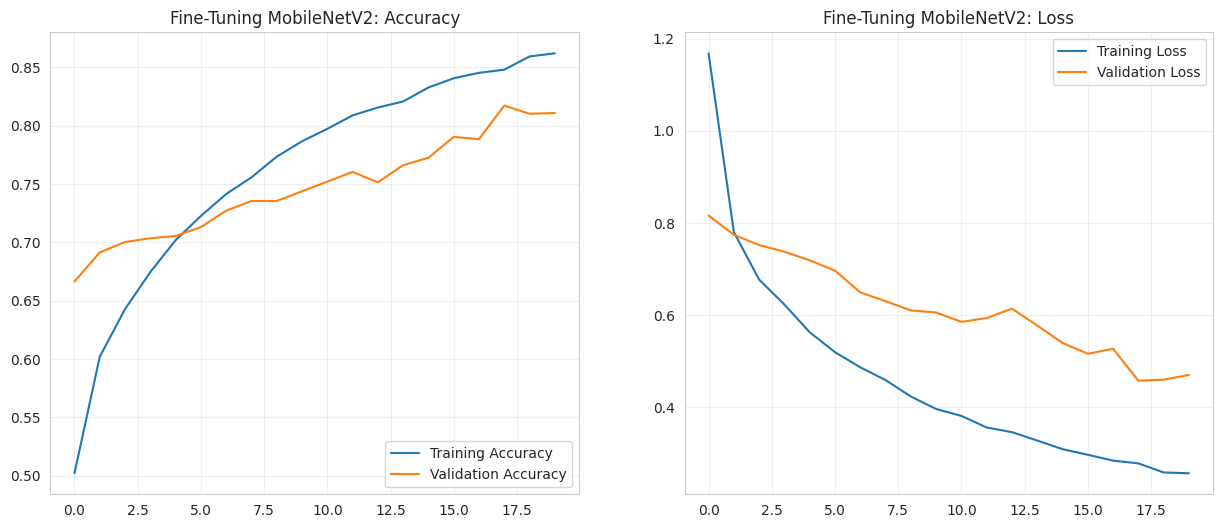


 EVALUASI AKHIR MOBILENET V2 FINE-TUNED 
Sedang memuat model dari model_mobilenetv2_finetuned.h5...


Sedang melakukan prediksi...
1565/1565 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step

=== CLASSIFICATION REPORT (MOBILENET V2 FINE-TUNED) ===
                       precision    recall  f1-score   support

            Big Truck       0.97      1.00      0.98        58
             City Car       0.90      0.64      0.74       466
Multi Purpose Vehicle       0.59      0.82      0.69       265
                Sedan       0.86      0.89      0.87       262
Sport Utility Vehicle       0.75      0.85      0.80       182
                Truck       1.00      0.99      1.00       115
                  Van       0.97      0.98      0.97       217

             accuracy                           0.82      1565
            macro avg       0.86      0.88      0.86      1565
         weighted avg       0.84      0.82      0.82      1565



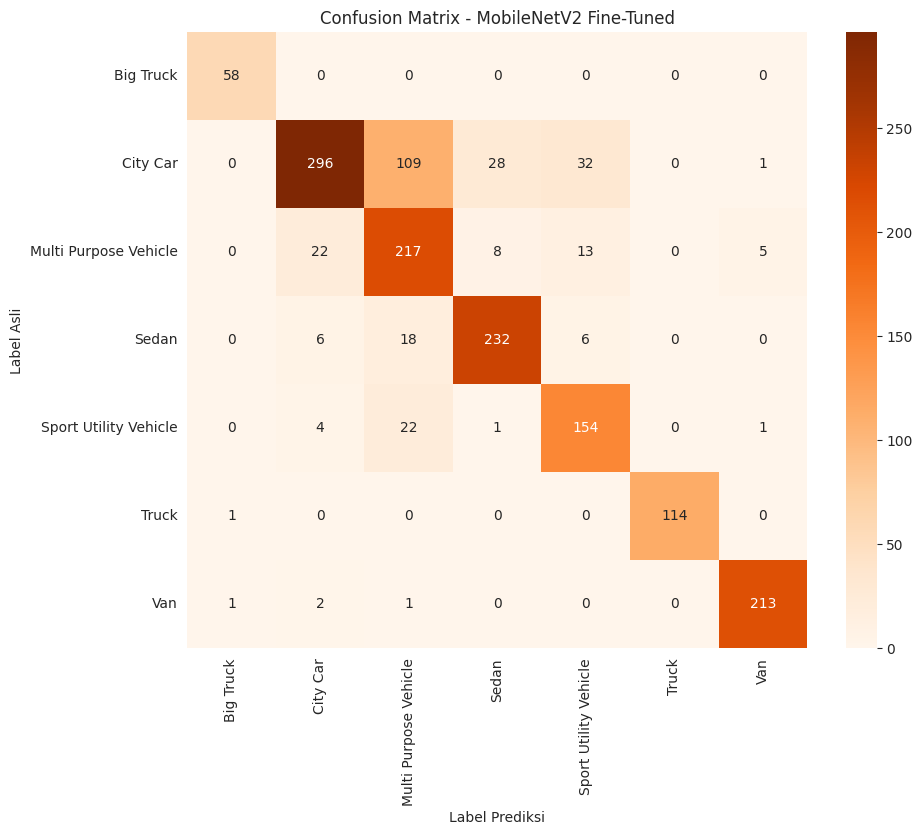

In [ ]:
def plot_mobile_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(15, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Fine-Tuning MobileNetV2: Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Fine-Tuning MobileNetV2: Loss')
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    plt.show()

if 'history_mobile_ft' in globals():
    plot_mobile_history(history_mobile_ft)


print("\n" + "="*50)
print(" EVALUASI AKHIR MOBILENET V2 FINE-TUNED ")
print("="*50)

model_path_mobile = 'model_mobilenetv2_finetuned.h5'

try:
    print(f"Sedang memuat model dari {model_path_mobile}...")
    final_mobile_model = load_model(model_path_mobile)
    
    test_gen_tl.reset()
    
    print("Sedang melakukan prediksi...")
    predictions = final_mobile_model.predict(test_gen_tl, verbose=1)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_gen_tl.classes
    class_names = list(test_gen_tl.class_indices.keys())

    print("\n=== CLASSIFICATION REPORT (MOBILENET V2 FINE-TUNED) ===")
    print(classification_report(y_true, y_pred, target_names=class_names))


    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix - MobileNetV2 Fine-Tuned')
    plt.ylabel('Label Asli')
    plt.xlabel('Label Prediksi')
    plt.show()

except Exception as e:
    print(f"Error: {e}")

TAHAP 3D: Menguji gambar dari link Google

Menguji gambar dari link Google...
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


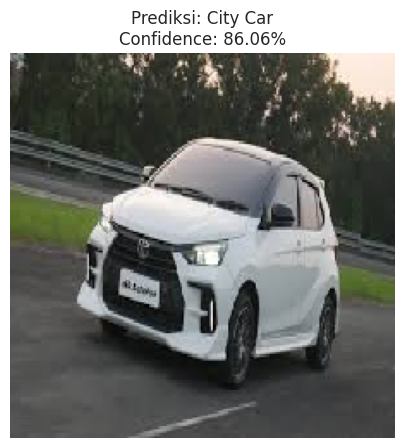

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import requests
from io import BytesIO
from tensorflow.keras.models import load_model
import tensorflow as tf

final_model = load_model('model_mobilenetv2_finetuned.h5')

class_names = ['Big Truck', 'City Car', 'Multi Purpose Vehicle', 'Sedan', 'Sport Utility Vehicle', 'Truck', 'Van']

def predict_external_image(image_url):
    try:
        response = requests.get(image_url)
        img = image.load_img(BytesIO(response.content), target_size=(224, 224))
        
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0 
        
        predictions = final_model.predict(img_array)
        predicted_class_idx = np.argmax(predictions)
        predicted_class = class_names[predicted_class_idx]
        confidence = 100 * np.max(predictions)
        
        plt.figure(figsize=(5, 5))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Prediksi: {predicted_class}\nConfidence: {confidence:.2f}%")
        plt.show()
        
    except Exception as e:
        print(f"Gagal memproses gambar: {e}")


url_pilihan_anda = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTvgX_ySL4Z-KeElNaxz6GptPz9GYoThV1xBQ&s"

print("Menguji gambar dari link Google...")
predict_external_image(url_pilihan_anda)

# TAHAP 4: TRAINING MODEL 2 - RESNET50 V2

In [ ]:
print("\n" + "="*40)
print(" MULAI TRAINING MODEL 2: RESNET50 V2 ")
print("="*40)

model_resnet = build_transfer_model('ResNet50V2')
model_resnet.summary()

ckpt_resnet = ModelCheckpoint(
    'model_resnet50_best.h5', 
    monitor='val_accuracy', save_best_only=True, mode='max', verbose=1
)
callbacks_resnet = [
    EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss'),
    ReduceLROnPlateau(factor=0.5, patience=3, monitor='val_loss'),
    ckpt_resnet
]

history_resnet = model_resnet.fit(
    train_gen_tl,
    validation_data=val_gen_tl,
    epochs=20,
    callbacks=callbacks_resnet,
    class_weight=class_weights_dict
)


 MULAI TRAINING MODEL 2: RESNET50 V2 


Model: "ResNet50V2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,091,143 (91.90 MB)

 Trainable params: 526,343 (2.01 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

Epoch 1/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.3063 - loss: 1.6710
Epoch 1: val_accuracy improved from -inf to 0.54569, saving model to model_resnet50_best.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 158s 379ms/step - accuracy: 0.3065 - loss: 1.6703 - val_accuracy: 0.5457 - val_loss: 1.1849 - learning_rate: 1.0000e-04
Epoch 2/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.4762 - loss: 1.1258
Epoch 2: val_accuracy improved from 0.54569 to 0.57444, saving model to model_resnet50_best.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 142s 363ms/step - accuracy: 0.4763 - loss: 1.1257 - val_accuracy: 0.5744 - val_loss: 1.0763 - learning_rate: 1.0000e-04
Epoch 3/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.5365 - loss: 0.9839
Epoch 3: val_accuracy improved from 0.57444 to 0.61086, saving model to model_resnet50_best.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 143s 364ms/step - accuracy: 0.5365 - loss: 0.9839 - val_accuracy: 0.6109 - val_loss: 1.0072 - learning_rate: 1.0000e-04
Epoch 4/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.5504 - loss: 0.9180
Epoch 4: val_accuracy did not improve from 0.61086
392/392 ━━━━━━━━━━━━━━━━━━━━ 141s 359ms/step - accuracy: 0.5504 - loss: 0.9179 - val_accuracy: 0.6109 - val_loss: 0.9816 - learning_rate: 1.0000e-04
Epoch 5/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.5819 - loss: 0.8569
Epoch 5: val_accuracy improved from 0.61086 to 0.66262, saving model to model_resnet50_best.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 138s 351ms/step - accuracy: 0.5819 - loss: 0.8569 - val_accuracy: 0.6626 - val_loss: 0.9001 - learning_rate: 1.0000e-04
Epoch 6/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.6129 - loss: 0.7926
Epoch 6: val_accuracy improved from 0.66262 to 0.66390, saving model to model_resnet50_best.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 138s 353ms/step - accuracy: 0.6129 - loss: 0.7926 - val_accuracy: 0.6639 - val_loss: 0.8803 - learning_rate: 1.0000e-04
Epoch 7/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.6120 - loss: 0.7831
Epoch 7: val_accuracy improved from 0.66390 to 0.67220, saving model to model_resnet50_best.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 137s 350ms/step - accuracy: 0.6120 - loss: 0.7831 - val_accuracy: 0.6722 - val_loss: 0.8587 - learning_rate: 1.0000e-04
Epoch 8/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.6301 - loss: 0.7416
Epoch 8: val_accuracy improved from 0.67220 to 0.68626, saving model to model_resnet50_best.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 138s 351ms/step - accuracy: 0.6301 - loss: 0.7416 - val_accuracy: 0.6863 - val_loss: 0.8361 - learning_rate: 1.0000e-04
Epoch 9/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.6387 - loss: 0.7189
Epoch 9: val_accuracy improved from 0.68626 to 0.69904, saving model to model_resnet50_best.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 140s 356ms/step - accuracy: 0.6387 - loss: 0.7189 - val_accuracy: 0.6990 - val_loss: 0.8056 - learning_rate: 1.0000e-04
Epoch 10/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.6448 - loss: 0.7144
Epoch 10: val_accuracy improved from 0.69904 to 0.70671, saving model to model_resnet50_best.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 142s 363ms/step - accuracy: 0.6448 - loss: 0.7144 - val_accuracy: 0.7067 - val_loss: 0.7840 - learning_rate: 1.0000e-04
Epoch 11/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.6568 - loss: 0.6838
Epoch 11: val_accuracy did not improve from 0.70671
392/392 ━━━━━━━━━━━━━━━━━━━━ 140s 356ms/step - accuracy: 0.6568 - loss: 0.6838 - val_accuracy: 0.6971 - val_loss: 0.7914 - learning_rate: 1.0000e-04
Epoch 12/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.6553 - loss: 0.6753
Epoch 12: val_accuracy improved from 0.70671 to 0.71438, saving model to model_resnet50_best.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 141s 359ms/step - accuracy: 0.6553 - loss: 0.6753 - val_accuracy: 0.7144 - val_loss: 0.7638 - learning_rate: 1.0000e-04
Epoch 13/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.6628 - loss: 0.6612
Epoch 13: val_accuracy improved from 0.71438 to 0.72204, saving model to model_resnet50_best.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 139s 355ms/step - accuracy: 0.6628 - loss: 0.6611 - val_accuracy: 0.7220 - val_loss: 0.7618 - learning_rate: 1.0000e-04
Epoch 14/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.6752 - loss: 0.6387
Epoch 14: val_accuracy did not improve from 0.72204
392/392 ━━━━━━━━━━━━━━━━━━━━ 139s 355ms/step - accuracy: 0.6752 - loss: 0.6387 - val_accuracy: 0.7220 - val_loss: 0.7403 - learning_rate: 1.0000e-04
Epoch 15/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.6827 - loss: 0.6218
Epoch 15: val_accuracy improved from 0.72204 to 0.72652, saving model to model_resnet50_best.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 139s 356ms/step - accuracy: 0.6827 - loss: 0.6218 - val_accuracy: 0.7265 - val_loss: 0.7283 - learning_rate: 1.0000e-04
Epoch 16/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.6772 - loss: 0.6302
Epoch 16: val_accuracy improved from 0.72652 to 0.73994, saving model to model_resnet50_best.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 139s 354ms/step - accuracy: 0.6772 - loss: 0.6302 - val_accuracy: 0.7399 - val_loss: 0.7238 - learning_rate: 1.0000e-04
Epoch 17/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.6855 - loss: 0.6161
Epoch 17: val_accuracy did not improve from 0.73994
392/392 ━━━━━━━━━━━━━━━━━━━━ 139s 355ms/step - accuracy: 0.6856 - loss: 0.6161 - val_accuracy: 0.7316 - val_loss: 0.7131 - learning_rate: 1.0000e-04
Epoch 18/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.6911 - loss: 0.6032
Epoch 18: val_accuracy did not improve from 0.73994
392/392 ━━━━━━━━━━━━━━━━━━━━ 140s 356ms/step - accuracy: 0.6911 - loss: 0.6032 - val_accuracy: 0.7246 - val_loss: 0.7172 - learning_rate: 1.0000e-04
Epoch 19/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.6972 - loss: 0.5910
Epoch 19: val_accuracy did not improve from 0.73994
392/392 ━━━━━━━━━━━━━━━━━━━━ 139s 355ms/step - accuracy: 0.6972 - loss: 0.5910 - val_accuracy: 0.7355 - val_loss: 0.7011 - learnin

TAHAP 4A: VISUALISASI HASIL TRAINING (ResNet50) dan EVALUASI AKHIR PADA DATA TEST

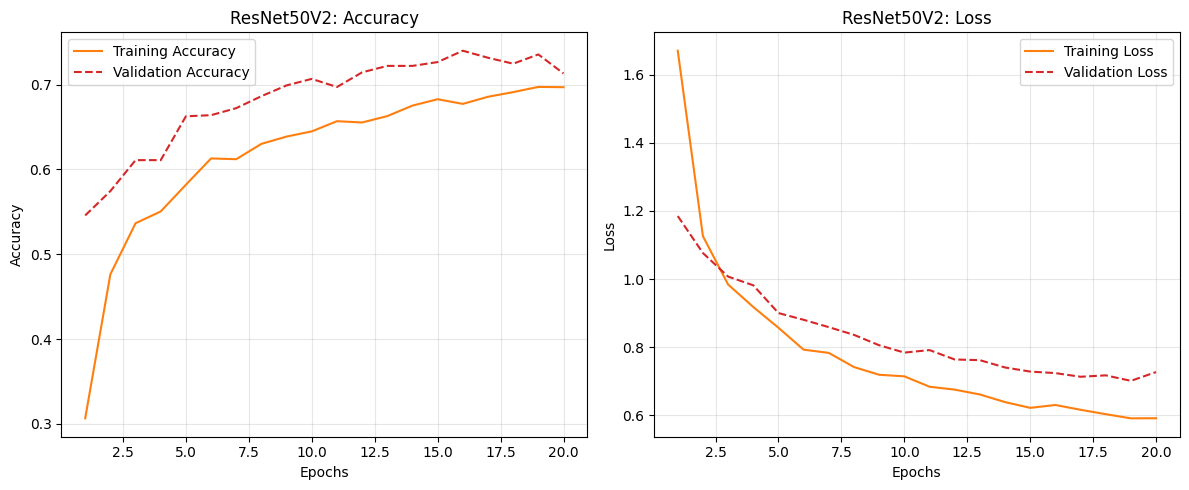


Executing Evaluation on Test Set (ResNet50V2 Frozen)...


Model loaded successfully from: /kaggle/working/model_resnet50_best.h5
1565/1565 ━━━━━━━━━━━━━━━━━━━━ 152s 96ms/step

=== CLASSIFICATION REPORT (RESNET50 V2 - FROZEN) ===
                       precision    recall  f1-score   support

            Big Truck       0.92      0.97      0.94        58
             City Car       0.75      0.56      0.64       466
Multi Purpose Vehicle       0.58      0.61      0.60       265
                Sedan       0.65      0.70      0.67       262
Sport Utility Vehicle       0.53      0.73      0.61       182
                Truck       0.97      0.95      0.96       115
                  Van       0.83      0.90      0.87       217

             accuracy                           0.70      1565
            macro avg       0.75      0.77      0.76      1565
         weighted avg       0.71      0.70      0.70      1565



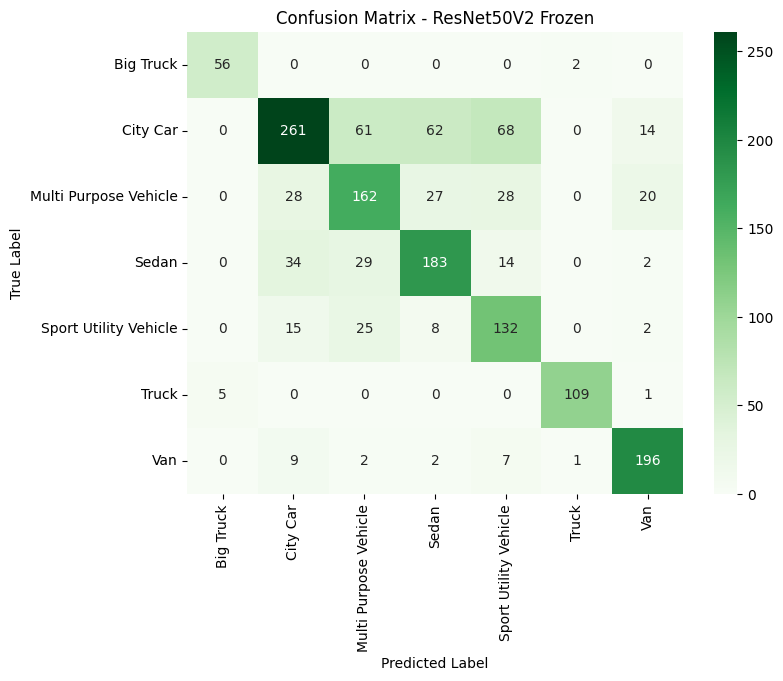

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix


def plot_resnet_history(history):

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))


    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy', color='#ff7f0e')
    plt.plot(epochs, val_acc, label='Validation Accuracy', color='#d62728', linestyle='--')
    plt.title('ResNet50V2 (Frozen Phase): Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss', color='#ff7f0e')
    plt.plot(epochs, val_loss, label='Validation Loss', color='#d62728', linestyle='--')
    plt.title('ResNet50V2 (Frozen Phase): Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


if 'history_resnet' in globals():
    plot_resnet_history(history_resnet)
else:
    print("Warning: Variabel 'history_resnet' tidak ditemukan. Pastikan nama variabel output model.fit() Anda adalah 'history_resnet'.")


print("\nExecuting Evaluation on Test Set (ResNet50V2 Model)...")
model_path = '/kaggle/working/model_resnet50_best.h5'

try:

    best_resnet_model = load_model(model_path)
    print(f"Model berhasil dimuat dari: {model_path}")
    
    if 'test_gen_tl' in globals():
        test_gen_tl.reset()
        
        print("Melakukan prediksi pada data test...")
        predictions = best_resnet_model.predict(test_gen_tl, verbose=1)
        y_pred = np.argmax(predictions, axis=1)
        y_true = test_gen_tl.classes
        class_names = list(test_gen_tl.class_indices.keys())

        print("\n=== CLASSIFICATION REPORT (RESNET50 V2) ===")
        print(classification_report(y_true, y_pred, target_names=class_names))
        
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(8, 6))

        sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
                    xticklabels=class_names, yticklabels=class_names)
        plt.title('Confusion Matrix - ResNet50V2')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()
    else:
        print("Error: Variabel 'test_gen_tl' tidak ditemukan. Harap definisikan generator data test.")

except Exception as e:
    print(f"Evaluasi gagal: {e}")
    print(f"Pastikan file '{model_path}' sudah terbentuk dari proses training sebelumnya.")

TAHAP 4B: FINE TUNING ResNet50V2

In [ ]:
print("Memuat Model ResNet50 Terbaik...")
model_finetune = tf.keras.models.load_model('model_resnet50_best.h5')


base_model = model_finetune.layers[1] 
base_model.trainable = True

fine_tune_at = 150

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

print(f"Jumlah layer total di Base Model: {len(base_model.layers)}")
print(f"Mulai Fine-Tuning dari layer ke: {fine_tune_at}")

model_finetune.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), 
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_finetune.summary()

print("\n=== MULAI FINE-TUNING RESNET50 ===")

ckpt_finetune = ModelCheckpoint(
    'model_resnet50_finetuned.h5', 
    monitor='val_accuracy', save_best_only=True, mode='max', verbose=1
)

callbacks_finetune = [
    EarlyStopping(patience=8, restore_best_weights=True, monitor='val_loss'),
    ReduceLROnPlateau(factor=0.2, patience=3, monitor='val_loss'),
    ckpt_finetune
]

history_finetune = model_finetune.fit(
    train_gen_tl,
    validation_data=val_gen_tl,
    epochs=20, 
    callbacks=callbacks_finetune,
    class_weight=class_weights_dict
)

Memuat Model ResNet50 Terbaik...


Jumlah layer total di Base Model: 190
Mulai Fine-Tuning dari layer ke: 150


Model: "ResNet50V2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,091,143 (91.90 MB)

 Trainable params: 15,760,391 (60.12 MB)

 Non-trainable params: 8,330,752 (31.78 MB)


=== MULAI FINE-TUNING RESNET50 ===
Epoch 1/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.5250 - loss: 1.0984
Epoch 1: val_accuracy improved from -inf to 0.70863, saving model to model_resnet50_finetuned.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 170s 387ms/step - accuracy: 0.5251 - loss: 1.0979 - val_accuracy: 0.7086 - val_loss: 0.7518 - learning_rate: 1.0000e-05
Epoch 2/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.6712 - loss: 0.6416
Epoch 2: val_accuracy improved from 0.70863 to 0.75655, saving model to model_resnet50_finetuned.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 141s 360ms/step - accuracy: 0.6712 - loss: 0.6416 - val_accuracy: 0.7565 - val_loss: 0.6319 - learning_rate: 1.0000e-05
Epoch 3/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.7259 - loss: 0.5238
Epoch 3: val_accuracy improved from 0.75655 to 0.78211, saving model to model_resnet50_finetuned.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 141s 361ms/step - accuracy: 0.7259 - loss: 0.5237 - val_accuracy: 0.7821 - val_loss: 0.5562 - learning_rate: 1.0000e-05
Epoch 4/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.7557 - loss: 0.4554
Epoch 4: val_accuracy improved from 0.78211 to 0.80703, saving model to model_resnet50_finetuned.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 142s 361ms/step - accuracy: 0.7557 - loss: 0.4553 - val_accuracy: 0.8070 - val_loss: 0.5068 - learning_rate: 1.0000e-05
Epoch 5/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.7897 - loss: 0.3940
Epoch 5: val_accuracy improved from 0.80703 to 0.83003, saving model to model_resnet50_finetuned.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 140s 357ms/step - accuracy: 0.7897 - loss: 0.3940 - val_accuracy: 0.8300 - val_loss: 0.4483 - learning_rate: 1.0000e-05
Epoch 6/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.8027 - loss: 0.3621
Epoch 6: val_accuracy improved from 0.83003 to 0.83323, saving model to model_resnet50_finetuned.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 147s 375ms/step - accuracy: 0.8028 - loss: 0.3620 - val_accuracy: 0.8332 - val_loss: 0.4287 - learning_rate: 1.0000e-05
Epoch 7/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.8249 - loss: 0.3226
Epoch 7: val_accuracy improved from 0.83323 to 0.85367, saving model to model_resnet50_finetuned.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 143s 364ms/step - accuracy: 0.8249 - loss: 0.3226 - val_accuracy: 0.8537 - val_loss: 0.3826 - learning_rate: 1.0000e-05
Epoch 8/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.8485 - loss: 0.2856
Epoch 8: val_accuracy improved from 0.85367 to 0.86837, saving model to model_resnet50_finetuned.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 140s 357ms/step - accuracy: 0.8485 - loss: 0.2856 - val_accuracy: 0.8684 - val_loss: 0.3592 - learning_rate: 1.0000e-05
Epoch 9/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.8558 - loss: 0.2628
Epoch 9: val_accuracy improved from 0.86837 to 0.88946, saving model to model_resnet50_finetuned.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 143s 365ms/step - accuracy: 0.8558 - loss: 0.2628 - val_accuracy: 0.8895 - val_loss: 0.3211 - learning_rate: 1.0000e-05
Epoch 10/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.8737 - loss: 0.2426
Epoch 10: val_accuracy improved from 0.88946 to 0.89649, saving model to model_resnet50_finetuned.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 141s 360ms/step - accuracy: 0.8737 - loss: 0.2426 - val_accuracy: 0.8965 - val_loss: 0.3038 - learning_rate: 1.0000e-05
Epoch 11/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.8801 - loss: 0.2158
Epoch 11: val_accuracy did not improve from 0.89649
392/392 ━━━━━━━━━━━━━━━━━━━━ 142s 361ms/step - accuracy: 0.8801 - loss: 0.2158 - val_accuracy: 0.8914 - val_loss: 0.2984 - learning_rate: 1.0000e-05
Epoch 12/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.8936 - loss: 0.1999
Epoch 12: val_accuracy improved from 0.89649 to 0.90288, saving model to model_resnet50_finetuned.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 141s 359ms/step - accuracy: 0.8936 - loss: 0.1999 - val_accuracy: 0.9029 - val_loss: 0.2727 - learning_rate: 1.0000e-05
Epoch 13/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.8984 - loss: 0.1862
Epoch 13: val_accuracy did not improve from 0.90288
392/392 ━━━━━━━━━━━━━━━━━━━━ 139s 355ms/step - accuracy: 0.8984 - loss: 0.1862 - val_accuracy: 0.8984 - val_loss: 0.2769 - learning_rate: 1.0000e-05
Epoch 14/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.9060 - loss: 0.1741
Epoch 14: val_accuracy improved from 0.90288 to 0.90351, saving model to model_resnet50_finetuned.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 147s 375ms/step - accuracy: 0.9060 - loss: 0.1741 - val_accuracy: 0.9035 - val_loss: 0.2536 - learning_rate: 1.0000e-05
Epoch 15/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.9147 - loss: 0.1664
Epoch 15: val_accuracy improved from 0.90351 to 0.91885, saving model to model_resnet50_finetuned.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 140s 358ms/step - accuracy: 0.9147 - loss: 0.1664 - val_accuracy: 0.9188 - val_loss: 0.2197 - learning_rate: 1.0000e-05
Epoch 16/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.9259 - loss: 0.1461
Epoch 16: val_accuracy did not improve from 0.91885
392/392 ━━━━━━━━━━━━━━━━━━━━ 141s 359ms/step - accuracy: 0.9259 - loss: 0.1461 - val_accuracy: 0.9188 - val_loss: 0.2224 - learning_rate: 1.0000e-05
Epoch 17/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.9220 - loss: 0.1462
Epoch 17: val_accuracy improved from 0.91885 to 0.92268, saving model to model_resnet50_finetuned.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 142s 363ms/step - accuracy: 0.9220 - loss: 0.1462 - val_accuracy: 0.9227 - val_loss: 0.2035 - learning_rate: 1.0000e-05
Epoch 18/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.9339 - loss: 0.1261
Epoch 18: val_accuracy improved from 0.92268 to 0.92588, saving model to model_resnet50_finetuned.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 141s 359ms/step - accuracy: 0.9339 - loss: 0.1261 - val_accuracy: 0.9259 - val_loss: 0.1955 - learning_rate: 1.0000e-05
Epoch 19/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.9388 - loss: 0.1179
Epoch 19: val_accuracy did not improve from 0.92588
392/392 ━━━━━━━━━━━━━━━━━━━━ 140s 356ms/step - accuracy: 0.9388 - loss: 0.1179 - val_accuracy: 0.9246 - val_loss: 0.2023 - learning_rate: 1.0000e-05
Epoch 20/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.9410 - loss: 0.1149
Epoch 20: val_accuracy improved from 0.92588 to 0.93099, saving model to model_resnet50_finetuned.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 139s 355ms/step - accuracy: 0.9410 - loss: 0.1149 - val_accuracy: 0.9310 - val_loss: 0.1936 - learning_rate: 1.0000e-05


TAHAP 4C: VISUALISASI HASIL TRAINING (RESNET50 FINE-TUNED) dan EVALUASI AKHIR PADA DATA TEST

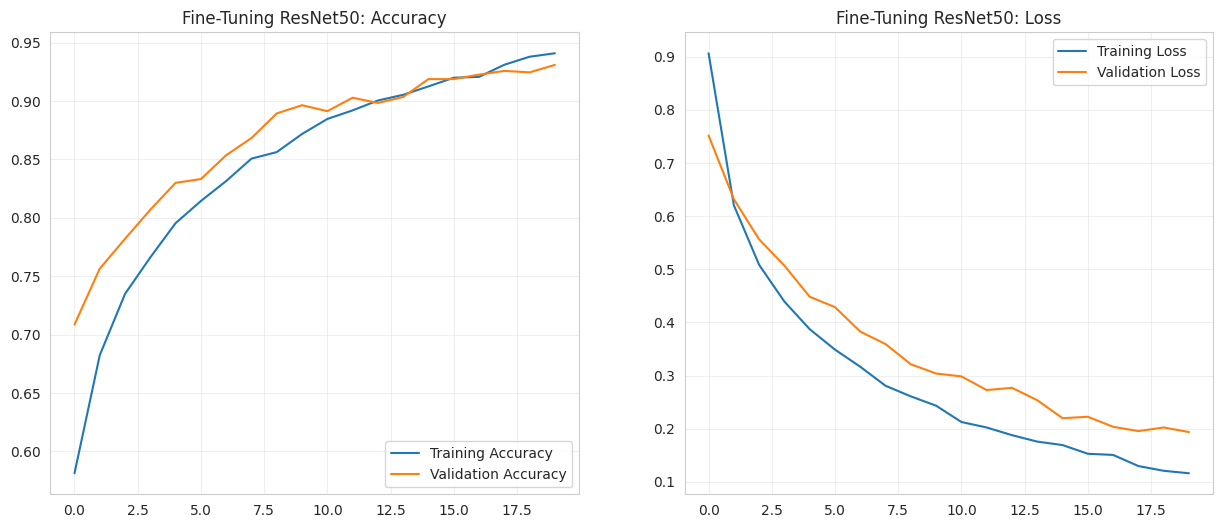


 EVALUASI AKHIR MODEL FINE-TUNED (DATA TEST) 
Sedang memuat model dari model_resnet50_finetuned.h5...


Sedang melakukan prediksi...
1565/1565 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step

=== CLASSIFICATION REPORT (RESNET50 FINE-TUNED) ===
                       precision    recall  f1-score   support

            Big Truck       0.98      1.00      0.99        58
             City Car       0.93      0.90      0.91       466
Multi Purpose Vehicle       0.85      0.82      0.84       265
                Sedan       0.96      0.94      0.95       262
Sport Utility Vehicle       0.86      0.97      0.91       182
                Truck       1.00      0.99      1.00       115
                  Van       0.96      1.00      0.98       217

             accuracy                           0.92      1565
            macro avg       0.94      0.95      0.94      1565
         weighted avg       0.93      0.92      0.92      1565



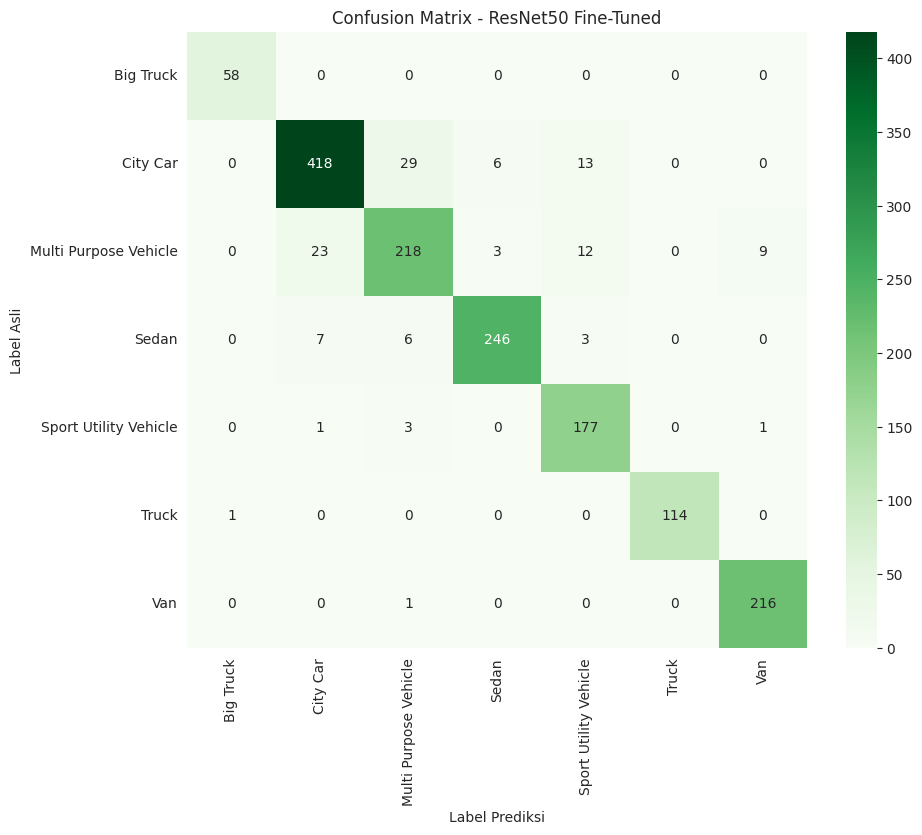


=== RINGKASAN EKSPERIMEN ===
                     Model   Status                            Deskripsi
0       Base CNN (Scratch)  Selesai         Dilatih dari nol, 128x128 px
1     MobileNetV2 (Frozen)  Selesai        Transfer Learning, bobot beku
2      ResNet50V2 (Frozen)  Selesai        Transfer Learning, bobot beku
3  ResNet50V2 (Fine-Tuned)  Selesai  Lanjutan ResNet, 40 layer dicairkan

Silakan isi tabel perbandingan akurasi di laporan berdasarkan 'val_accuracy' terbaik dari setiap tahap.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model

def plot_finetune_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(15, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Fine-Tuning ResNet50: Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Fine-Tuning ResNet50: Loss')
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    plt.show()

if 'history_finetune' in globals():
    plot_finetune_history(history_finetune)
else:
    print("Variabel 'history_finetune' tidak ditemukan. Pastikan training fine-tuning sudah selesai.")


print("\n" + "="*50)
print(" EVALUASI AKHIR MODEL FINE-TUNED (DATA TEST) ")
print("="*50)

model_path = 'model_resnet50_finetuned.h5'

try:
    print(f"Sedang memuat model dari {model_path}...")
    final_model = load_model(model_path)
    

    test_gen_tl.reset()
    

    print("Sedang melakukan prediksi...")
    predictions = final_model.predict(test_gen_tl, verbose=1)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_gen_tl.classes
    class_names = list(test_gen_tl.class_indices.keys())


    print("\n=== CLASSIFICATION REPORT (RESNET50 FINE-TUNED) ===")
    report_dict = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix - ResNet50 Fine-Tuned')
    plt.ylabel('Label Asli')
    plt.xlabel('Label Prediksi')
    plt.show()

except Exception as e:
    print(f"Gagal memuat model atau evaluasi: {e}")
    print("Pastikan file .h5 sudah terbentuk dan path-nya benar.")



summary_data = {
    'Model': ['Base CNN (Scratch)', 'MobileNetV2 (Frozen)', 'ResNet50V2 (Frozen)', 'ResNet50V2 (Fine-Tuned)'],
    'Status': ['Selesai', 'Selesai', 'Selesai', 'Selesai'],
    'Deskripsi': [
        'Dilatih dari nol, 128x128 px', 
        'Transfer Learning, bobot beku', 
        'Transfer Learning, bobot beku', 
        'Lanjutan ResNet, 40 layer dicairkan'
    ]
}

df_summary = pd.DataFrame(summary_data)
print("\n=== RINGKASAN EKSPERIMEN ===")
print(df_summary)
print("\nSilakan isi tabel perbandingan akurasi di laporan berdasarkan 'val_accuracy' terbaik dari setiap tahap.")

TAHAP 4D: Menguji gambar dari link Google

Menguji gambar dari link Google...
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


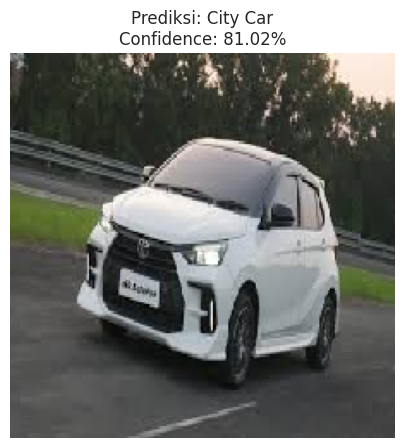

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import requests
from io import BytesIO
from tensorflow.keras.models import load_model
import tensorflow as tf

final_model = load_model('model_resnet50_finetuned.h5')

class_names = ['Big Truck', 'City Car', 'Multi Purpose Vehicle', 'Sedan', 'Sport Utility Vehicle', 'Truck', 'Van']

def predict_external_image(image_url):
    try:

        response = requests.get(image_url)

        img = image.load_img(BytesIO(response.content), target_size=(224, 224))
        
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0 
        
        predictions = final_model.predict(img_array)
        predicted_class_idx = np.argmax(predictions)
        predicted_class = class_names[predicted_class_idx]
        confidence = 100 * np.max(predictions)
        
        plt.figure(figsize=(5, 5))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Prediksi: {predicted_class}\nConfidence: {confidence:.2f}%")
        plt.show()
        
    except Exception as e:
        print(f"Gagal memproses gambar: {e}")


url_pilihan_anda = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTvgX_ySL4Z-KeElNaxz6GptPz9GYoThV1xBQ&s"

print("Menguji gambar dari link Google...")
predict_external_image(url_pilihan_anda)

# TAHAP 5: MEMBANGUN MODEL EFFICIENTNET B0 (FROZEN)

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

print("Membangun EfficientNetB0 dengan bobot ImageNet dibekukan...")

base_model_eff = EfficientNetB0(
    weights='imagenet', 
    include_top=False, 
    input_shape=(224, 224, 3)
)

base_model_eff.trainable = False

inputs = Input(shape=(224, 224, 3))

x = base_model_eff(inputs, training=False) 
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x) 
outputs = Dense(7, activation='softmax')(x)

model_eff_frozen = Model(inputs, outputs, name="EfficientNetB0_Frozen")

model_eff_frozen.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_eff_frozen.summary()


print("\n" + "="*40)
print(" MULAI TRAINING EFFICIENTNET B0 (FROZEN) ")
print("="*40)


ckpt_eff_frozen = ModelCheckpoint(
    'model_effb0_frozen_best.h5', 
    monitor='val_accuracy', save_best_only=True, mode='max', verbose=1
)

callbacks_eff = [
    EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss'),
    ReduceLROnPlateau(factor=0.5, patience=3, monitor='val_loss'),
    ckpt_eff_frozen
]

history_eff_frozen = model_eff_frozen.fit(
    train_gen_tl,
    validation_data=val_gen_tl,
    epochs=20, 
    callbacks=callbacks_eff,
    class_weight=class_weights_dict
)



Membangun EfficientNetB0 dengan bobot ImageNet dibekukan...
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "EfficientNetB0_Frozen"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,379,306 (16.71 MB)

 Trainable params: 329,735 (1.26 MB)

 Non-trainable params: 4,049,571 (15.45 MB)


 MULAI TRAINING EFFICIENTNET B0 (FROZEN) 
Epoch 1/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - accuracy: 0.1368 - loss: 1.9621
Epoch 1: val_accuracy improved from -inf to 0.03642, saving model to model_effb0_frozen_best.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 182s 414ms/step - accuracy: 0.1368 - loss: 1.9621 - val_accuracy: 0.0364 - val_loss: 1.9500 - learning_rate: 1.0000e-04
Epoch 2/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.1461 - loss: 1.9485
Epoch 2: val_accuracy improved from 0.03642 to 0.29776, saving model to model_effb0_frozen_best.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 136s 347ms/step - accuracy: 0.1461 - loss: 1.9485 - val_accuracy: 0.2978 - val_loss: 1.9394 - learning_rate: 1.0000e-04
Epoch 3/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.1312 - loss: 1.9598
Epoch 3: val_accuracy did not improve from 0.29776
392/392 ━━━━━━━━━━━━━━━━━━━━ 134s 343ms/step - accuracy: 0.1312 - loss: 1.9598 - val_accuracy: 0.1169 - val_loss: 1.9474 - learning_rate: 1.0000e-04
Epoch 4/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.1212 - loss: 1.9578
Epoch 4: val_accuracy did not improve from 0.29776
392/392 ━━━━━━━━━━━━━━━━━━━━ 136s 347ms/step - accuracy: 0.1212 - loss: 1.9578 - val_accuracy: 0.2978 - val_loss: 1.9437 - learning_rate: 1.0000e-04
Epoch 5/20
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.1644 - loss: 1.9750
Epoch 5: val_accuracy did not improve from 0.29776
392/392 ━━━━━━━━━━━━━━━━━━━━ 137s 348ms/step - accuracy: 0.1643 - loss: 1.9749 - val_accuracy: 0.1169 - val_loss: 1.9461 - learning_rate

TAHAP 5B: VISUALISASI HASIL TRAINING (EFFICIENTNET B0) dan EVALUASI AKHIR PADA DATA TEST

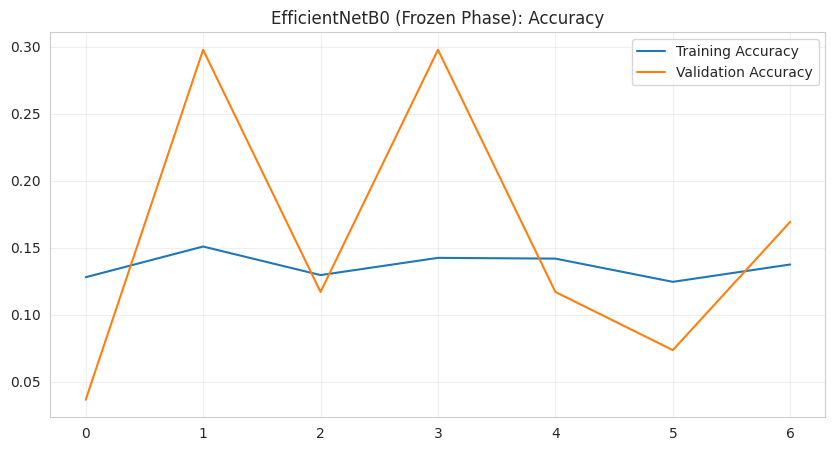


Executing Evaluation on Test Set (Frozen Model)...


1565/1565 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step

=== CLASSIFICATION REPORT (EFFICIENTNET B0 - FROZEN) ===
                       precision    recall  f1-score   support

            Big Truck       0.00      0.00      0.00        58
             City Car       0.30      1.00      0.46       466
Multi Purpose Vehicle       0.00      0.00      0.00       265
                Sedan       0.00      0.00      0.00       262
Sport Utility Vehicle       0.00      0.00      0.00       182
                Truck       0.00      0.00      0.00       115
                  Van       0.00      0.00      0.00       217

             accuracy                           0.30      1565
            macro avg       0.04      0.14      0.07      1565
         weighted avg       0.09      0.30      0.14      1565



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


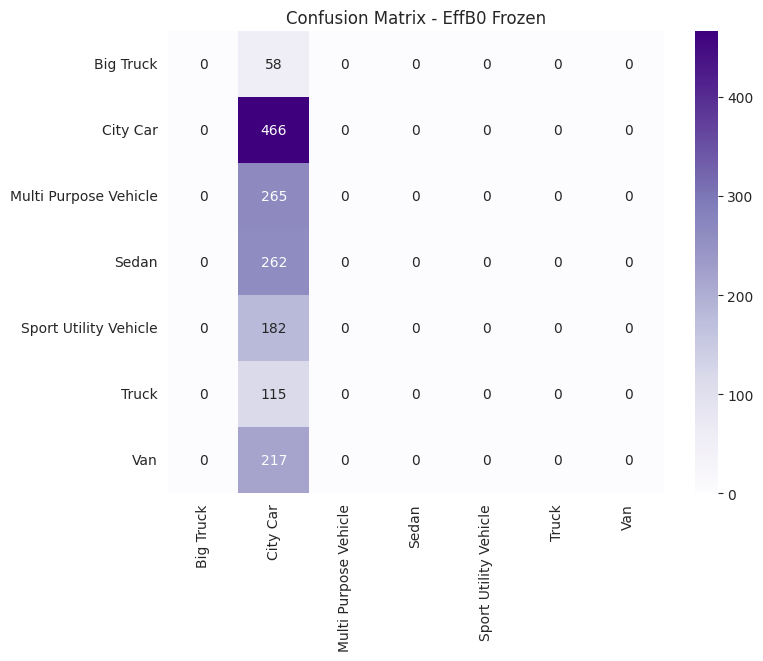

In [ ]:
def plot_eff_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(len(acc))
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('EfficientNetB0 (Frozen Phase): Accuracy')
    plt.legend(); plt.grid(True, alpha=0.3); plt.show()

if 'history_eff_frozen' in globals():
    plot_eff_history(history_eff_frozen)

print("\nExecuting Evaluation on Test Set (Frozen Model)...")
try:
    best_eff_frozen = load_model('model_effb0_frozen_best.h5')
    test_gen_tl.reset()
    
    predictions = best_eff_frozen.predict(test_gen_tl, verbose=1)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_gen_tl.classes
    class_names = list(test_gen_tl.class_indices.keys())

    print("\n=== CLASSIFICATION REPORT (EFFICIENTNET B0 - FROZEN) ===")
    print(classification_report(y_true, y_pred, target_names=class_names))
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix - EffB0 Frozen'); plt.show()

except Exception as e:
    print(f"Evaluasi gagal: {e}")

TAHAP 5C: FINE-TUNING EFFICIENTNET B0 

In [ ]:
print("\n" + "="*50)
print(" MULAI PENYELAMATAN: FINE-TUNING EFFICIENTNET B0 ")
print("="*50)

model_eff_frozen = load_model('model_effb0_frozen_best.h5') 

base_model_eff = model_eff_frozen.layers[1] 
base_model_eff.trainable = True

fine_tune_at = 50 

for layer in base_model_eff.layers[:fine_tune_at]:
    layer.trainable = False

print(f"Total layer EfficientNetB0: {len(base_model_eff.layers)}")
print(f"Melatih ulang (Fine-Tuning) mulai dari layer ke: {fine_tune_at}")

model_eff_frozen.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5), 
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

ckpt_eff_ft = ModelCheckpoint(
    'model_effb0_finetuned.h5', 
    monitor='val_accuracy', save_best_only=True, mode='max', verbose=1
)

callbacks_eff_ft = [
    EarlyStopping(patience=8, restore_best_weights=True, monitor='val_loss'),
    ReduceLROnPlateau(factor=0.2, patience=3, monitor='val_loss'),
    ckpt_eff_ft
]

history_eff_ft = model_eff_frozen.fit(
    train_gen_tl,
    validation_data=val_gen_tl,
    epochs=25, 
    callbacks=callbacks_eff_ft,
    class_weight=class_weights_dict
)




 MULAI PENYELAMATAN: FINE-TUNING EFFICIENTNET B0 
Total layer EfficientNetB0: 238
Melatih ulang (Fine-Tuning) mulai dari layer ke: 50
Epoch 1/25


2025-12-21 23:01:54.977363: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-21 23:01:55.166892: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-21 23:01:55.647258: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-21 23:01:55.853907: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-21 23:01:56.232829: E external/local_xla/xla/stream_

391/392 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy: 0.1986 - loss: 1.9326

2025-12-21 23:04:43.737420: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-21 23:04:43.922596: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-21 23:04:44.319517: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-12-21 23:04:44.524842: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.1987 - loss: 1.9323
Epoch 1: val_accuracy improved from -inf to 0.09137, saving model to model_effb0_finetuned.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 241s 464ms/step - accuracy: 0.1988 - loss: 1.9321 - val_accuracy: 0.0914 - val_loss: 1.9699 - learning_rate: 2.0000e-05
Epoch 2/25
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.3139 - loss: 1.5429
Epoch 2: val_accuracy improved from 0.09137 to 0.36230, saving model to model_effb0_finetuned.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 142s 362ms/step - accuracy: 0.3140 - loss: 1.5427 - val_accuracy: 0.3623 - val_loss: 1.4995 - learning_rate: 2.0000e-05
Epoch 3/25
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - accuracy: 0.3981 - loss: 1.2907
Epoch 3: val_accuracy improved from 0.36230 to 0.39489, saving model to model_effb0_finetuned.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 143s 365ms/step - accuracy: 0.3981 - loss: 1.2906 - val_accuracy: 0.3949 - val_loss: 1.3639 - learning_rate: 2.0000e-05
Epoch 4/25
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.4685 - loss: 1.1038
Epoch 4: val_accuracy improved from 0.39489 to 0.46965, saving model to model_effb0_finetuned.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 143s 363ms/step - accuracy: 0.4685 - loss: 1.1038 - val_accuracy: 0.4696 - val_loss: 1.1992 - learning_rate: 2.0000e-05
Epoch 5/25
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.5246 - loss: 0.9729
Epoch 5: val_accuracy improved from 0.46965 to 0.52396, saving model to model_effb0_finetuned.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 142s 361ms/step - accuracy: 0.5246 - loss: 0.9728 - val_accuracy: 0.5240 - val_loss: 1.1119 - learning_rate: 2.0000e-05
Epoch 6/25
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.5743 - loss: 0.8685
Epoch 6: val_accuracy improved from 0.52396 to 0.53610, saving model to model_effb0_finetuned.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 142s 361ms/step - accuracy: 0.5743 - loss: 0.8685 - val_accuracy: 0.5361 - val_loss: 1.0800 - learning_rate: 2.0000e-05
Epoch 7/25
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.5953 - loss: 0.7991
Epoch 7: val_accuracy improved from 0.53610 to 0.60831, saving model to model_effb0_finetuned.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 142s 361ms/step - accuracy: 0.5953 - loss: 0.7991 - val_accuracy: 0.6083 - val_loss: 0.9381 - learning_rate: 2.0000e-05
Epoch 8/25
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.6313 - loss: 0.7348
Epoch 8: val_accuracy did not improve from 0.60831
392/392 ━━━━━━━━━━━━━━━━━━━━ 141s 360ms/step - accuracy: 0.6313 - loss: 0.7348 - val_accuracy: 0.6070 - val_loss: 0.9149 - learning_rate: 2.0000e-05
Epoch 9/25
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.6547 - loss: 0.6802
Epoch 9: val_accuracy improved from 0.60831 to 0.63962, saving model to model_effb0_finetuned.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 142s 362ms/step - accuracy: 0.6547 - loss: 0.6802 - val_accuracy: 0.6396 - val_loss: 0.8430 - learning_rate: 2.0000e-05
Epoch 10/25
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.6706 - loss: 0.6466
Epoch 10: val_accuracy improved from 0.63962 to 0.68051, saving model to model_effb0_finetuned.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 142s 363ms/step - accuracy: 0.6706 - loss: 0.6466 - val_accuracy: 0.6805 - val_loss: 0.7716 - learning_rate: 2.0000e-05
Epoch 11/25
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.6932 - loss: 0.5960
Epoch 11: val_accuracy did not improve from 0.68051
392/392 ━━━━━━━━━━━━━━━━━━━━ 141s 360ms/step - accuracy: 0.6932 - loss: 0.5960 - val_accuracy: 0.6607 - val_loss: 0.7764 - learning_rate: 2.0000e-05
Epoch 12/25
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.7111 - loss: 0.5726
Epoch 12: val_accuracy improved from 0.68051 to 0.69457, saving model to model_effb0_finetuned.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 145s 370ms/step - accuracy: 0.7111 - loss: 0.5726 - val_accuracy: 0.6946 - val_loss: 0.7217 - learning_rate: 2.0000e-05
Epoch 13/25
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - accuracy: 0.7203 - loss: 0.5344
Epoch 13: val_accuracy improved from 0.69457 to 0.70351, saving model to model_effb0_finetuned.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 143s 365ms/step - accuracy: 0.7204 - loss: 0.5343 - val_accuracy: 0.7035 - val_loss: 0.7025 - learning_rate: 2.0000e-05
Epoch 14/25
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.7346 - loss: 0.5187
Epoch 14: val_accuracy improved from 0.70351 to 0.73291, saving model to model_effb0_finetuned.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 141s 360ms/step - accuracy: 0.7346 - loss: 0.5186 - val_accuracy: 0.7329 - val_loss: 0.6282 - learning_rate: 2.0000e-05
Epoch 15/25
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.7448 - loss: 0.4855
Epoch 15: val_accuracy improved from 0.73291 to 0.75144, saving model to model_effb0_finetuned.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 143s 365ms/step - accuracy: 0.7448 - loss: 0.4855 - val_accuracy: 0.7514 - val_loss: 0.6032 - learning_rate: 2.0000e-05
Epoch 16/25
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.7602 - loss: 0.4575
Epoch 16: val_accuracy did not improve from 0.75144
392/392 ━━━━━━━━━━━━━━━━━━━━ 147s 374ms/step - accuracy: 0.7602 - loss: 0.4575 - val_accuracy: 0.7227 - val_loss: 0.6392 - learning_rate: 2.0000e-05
Epoch 17/25
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.7611 - loss: 0.4575
Epoch 17: val_accuracy did not improve from 0.75144
392/392 ━━━━━━━━━━━━━━━━━━━━ 145s 370ms/step - accuracy: 0.7612 - loss: 0.4575 - val_accuracy: 0.7489 - val_loss: 0.5872 - learning_rate: 2.0000e-05
Epoch 18/25
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.7682 - loss: 0.4369
Epoch 18: val_accuracy did not improve from 0.75144
392/392 ━━━━━━━━━━━━━━━━━━━━ 141s 359ms/step - accuracy: 0.7682 - loss: 0.4368 - val_accuracy: 0.7438 - val_loss: 0.5947 - learnin

392/392 ━━━━━━━━━━━━━━━━━━━━ 140s 356ms/step - accuracy: 0.7940 - loss: 0.3948 - val_accuracy: 0.7681 - val_loss: 0.5482 - learning_rate: 2.0000e-05
Epoch 21/25
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.8007 - loss: 0.3780
Epoch 21: val_accuracy improved from 0.76805 to 0.77955, saving model to model_effb0_finetuned.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 142s 362ms/step - accuracy: 0.8007 - loss: 0.3780 - val_accuracy: 0.7796 - val_loss: 0.5261 - learning_rate: 2.0000e-05
Epoch 22/25
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.8130 - loss: 0.3480
Epoch 22: val_accuracy did not improve from 0.77955
392/392 ━━━━━━━━━━━━━━━━━━━━ 142s 363ms/step - accuracy: 0.8130 - loss: 0.3480 - val_accuracy: 0.7719 - val_loss: 0.5413 - learning_rate: 2.0000e-05
Epoch 23/25
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.8234 - loss: 0.3411
Epoch 23: val_accuracy improved from 0.77955 to 0.80064, saving model to model_effb0_finetuned.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 143s 366ms/step - accuracy: 0.8234 - loss: 0.3411 - val_accuracy: 0.8006 - val_loss: 0.4832 - learning_rate: 2.0000e-05
Epoch 24/25
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.8282 - loss: 0.3330
Epoch 24: val_accuracy improved from 0.80064 to 0.81086, saving model to model_effb0_finetuned.h5


392/392 ━━━━━━━━━━━━━━━━━━━━ 146s 373ms/step - accuracy: 0.8282 - loss: 0.3330 - val_accuracy: 0.8109 - val_loss: 0.4647 - learning_rate: 2.0000e-05
Epoch 25/25
392/392 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.8390 - loss: 0.3121
Epoch 25: val_accuracy did not improve from 0.81086
392/392 ━━━━━━━━━━━━━━━━━━━━ 142s 361ms/step - accuracy: 0.8389 - loss: 0.3121 - val_accuracy: 0.8032 - val_loss: 0.4916 - learning_rate: 2.0000e-05


TAHAP 5D: VISUALISASI HASIL FINE-TUNING EFFICIENTNET B0 

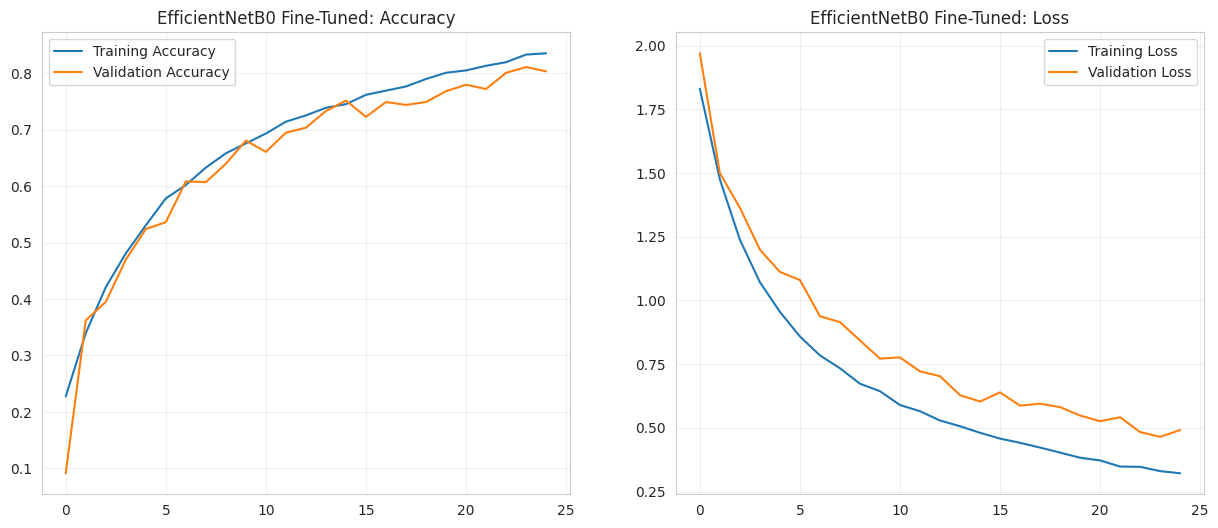

In [ ]:
def plot_eff_ft_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('EfficientNetB0 Fine-Tuned: Accuracy')
    plt.legend(); plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('EfficientNetB0 Fine-Tuned: Loss')
    plt.legend(); plt.grid(True, alpha=0.3); plt.show()

if 'history_eff_ft' in globals():
    plot_eff_ft_history(history_eff_ft)

TAHAP 5E: EVALUASI FINE-TUNING EFFICIENTNET B0 

Sedang menyimpan ulang model ke format baru: model_effb0_finetuned_FIXED.keras...
✅ Berhasil disimpan!

Memuat kembali model dari model_effb0_finetuned_FIXED.keras...


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 175 variables whereas the saved optimizer has 348 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Sedang melakukan prediksi ulang...
1565/1565 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step

=== CLASSIFICATION REPORT (FORMAT .KERAS) ===
                       precision    recall  f1-score   support

            Big Truck       0.98      0.98      0.98        58
             City Car       0.84      0.68      0.75       466
Multi Purpose Vehicle       0.67      0.69      0.68       265
                Sedan       0.68      0.89      0.77       262
Sport Utility Vehicle       0.81      0.87      0.84       182
                Truck       1.00      0.98      0.99       115
                  Van       0.97      0.90      0.94       217

             accuracy                           0.80      1565
            macro avg       0.85      0.86      0.85      1565
         weighted avg       0.82      0.80      0.80      1565



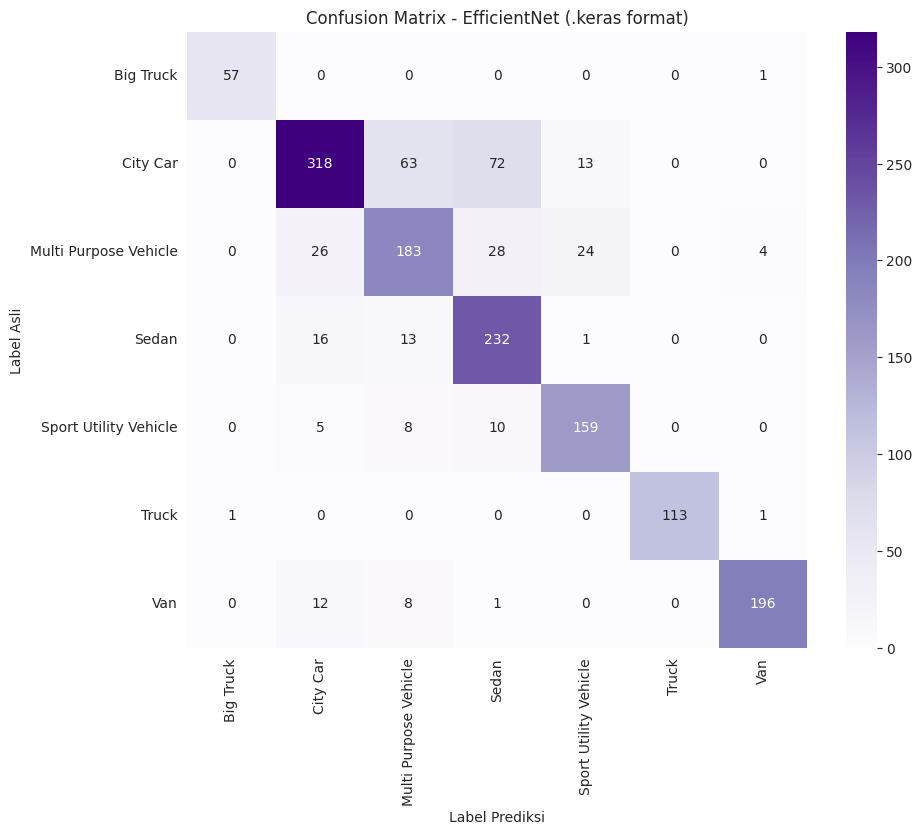

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model

new_filename = 'model_effb0_finetuned_FIXED.keras' 

print(f"Sedang menyimpan ulang model ke format baru: {new_filename}...")


model_eff_frozen.save(new_filename)

print("✅ Berhasil disimpan!")


print(f"\nMemuat kembali model dari {new_filename}...")

model_final_fix = load_model(new_filename)

print("Sedang melakukan prediksi ulang...")
test_gen_tl.reset()


predictions = model_final_fix.predict(test_gen_tl, verbose=1)
y_pred = np.argmax(predictions, axis=1)
y_true = test_gen_tl.classes
class_names = list(test_gen_tl.class_indices.keys())


print("\n=== CLASSIFICATION REPORT (FORMAT .KERAS) ===")
print(classification_report(y_true, y_pred, target_names=class_names))


cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - EfficientNet (.keras format)')
plt.ylabel('Label Asli')
plt.xlabel('Label Prediksi')
plt.show()

# VISUALISASI PERBANDINGAN FINAL

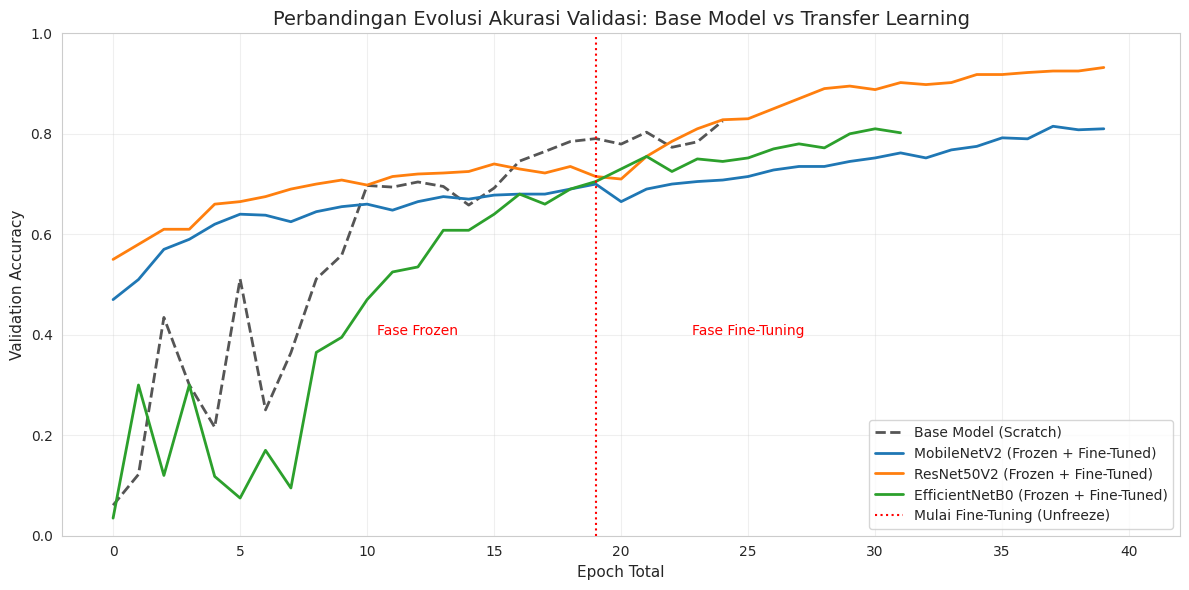

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))


acc_mobile_total = history_mobile.history['val_accuracy'] + history_mobile_ft.history['val_accuracy']


acc_resnet_total = history_resnet.history['val_accuracy'] + history_finetune.history['val_accuracy']

acc_eff_total = history_eff_frozen.history['val_accuracy'] + history_eff_ft.history['val_accuracy']


acc_base = history_base.history['val_accuracy']



plt.plot(acc_base, label='Base Model (Scratch)', linestyle='--', color='black', linewidth=2, alpha=0.7)


plt.plot(acc_mobile_total, label='MobileNetV2 (Frozen + Fine-Tuned)', linewidth=2)
plt.plot(acc_resnet_total, label='ResNet50V2 (Frozen + Fine-Tuned)', linewidth=2)
plt.plot(acc_eff_total, label='EfficientNetB0 (Frozen + Fine-Tuned)', linewidth=2)



batas_ft = len(history_mobile.history['val_accuracy']) - 1
plt.axvline(x=batas_ft, color='red', linestyle=':', label='Mulai Fine-Tuning (Unfreeze)')

plt.text(batas_ft - 5, 0.4, 'Fase Frozen', fontsize=12, color='red', ha='center')
plt.text(batas_ft + 5, 0.4, 'Fase Fine-Tuning', fontsize=12, color='red', ha='center')


plt.title('Perbandingan Evolusi Akurasi Validasi: Base Model vs Transfer Learning', fontsize=16)
plt.xlabel('Epoch Total', fontsize=12)
plt.ylabel('Validation Accuracy', fontsize=12)
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.ylim(0, 1.0) 

plt.show()


# PENYIMPANAN MASSAL KE FORMAT .KERAS (NATIVE)


In [ ]:
import os
import tensorflow as tf

print("=== MULAI PENYIMPANAN MASSAL KE FORMAT .KERAS ===")

models_to_save = {
    'Base Model': (model_base, 'model_base_final.keras'),
    'MobileNetV2 (Fine-Tuned)': (model_mobile_ft, 'model_mobilenetv2_finetuned.keras'),
    'ResNet50V2 (Fine-Tuned)': (model_finetune, 'model_resnet50_finetuned.keras'),
    'EfficientNetB0 (Fine-Tuned)': (model_eff_frozen, 'model_effb0_finetuned.keras') 

}

for name, (model_obj, filename) in models_to_save.items():
    try:
        print(f"\n💾 Menyimpan {name} ke '{filename}'...")
        

        model_obj.save(filename)

        if os.path.exists(filename):
            size_mb = os.path.getsize(filename) / (1024 * 1024)
            print(f"✅ SUKSES! Ukuran: {size_mb:.2f} MB")
        else:
            print(f"❌ GAGAL: File tidak ditemukan setelah disimpan.")
            
    except Exception as e:
        print(f"⚠️ ERROR saat menyimpan {name}: {e}")
        print("   (Mungkin variabel model sudah tertimpa atau tidak ada di memori)")

print("\n" + "="*50)
print(" SEMUA PROSES PENYIMPANAN SELESAI ")
print("="*50)
print("Tips: Segera download file-file .keras ini dari folder Output Kaggle.")

=== MULAI PENYIMPANAN MASSAL KE FORMAT .KERAS ===

💾 Menyimpan Base Model ke 'model_base_final.keras'...
✅ SUKSES! Ukuran: 58.58 MB

💾 Menyimpan MobileNetV2 (Fine-Tuned) ke 'model_mobilenetv2_finetuned.keras'...
✅ SUKSES! Ukuran: 27.19 MB

💾 Menyimpan ResNet50V2 (Fine-Tuned) ke 'model_resnet50_finetuned.keras'...
✅ SUKSES! Ukuran: 212.81 MB

💾 Menyimpan EfficientNetB0 (Fine-Tuned) ke 'model_effb0_finetuned.keras'...
✅ SUKSES! Ukuran: 50.55 MB

 SEMUA PROSES PENYIMPANAN SELESAI 
Tips: Segera download file-file .keras ini dari folder Output Kaggle.
